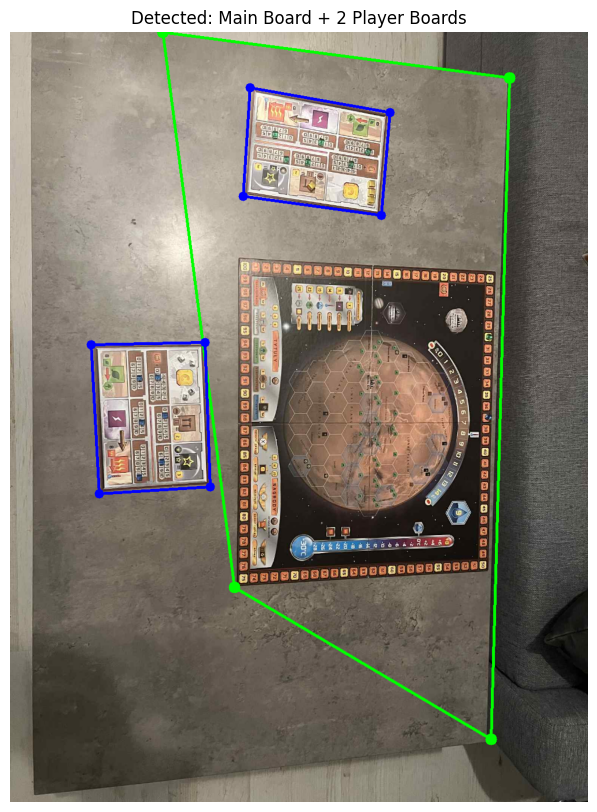

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_inline(img_bgr, title="Image"):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

def detect_game_components(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not find {image_path}")
        return None, None, []

    # Resize
    height, width = img.shape[:2]
    target_width = 1000
    scale = target_width / width
    dim = (target_width, int(height * scale))
    img_resized = cv2.resize(img, dim)
    
    # Process
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
    # TWEAK: Bilateral Filter
    blur = cv2.bilateralFilter(gray, 9, 75, 75)
    
    # Canny 
    edged = cv2.Canny(blur, 30, 100)
    
    # Dilation to close gaps
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edged, kernel, iterations=2)

    # Find Contours and sort by Area (Largest first)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    map_contour_result = None
    player_board_contours = []
    
    # We need the main board area to filter player boards relatively
    main_board_area = 0

    # --- PASS 1: Find the Main Board (Largest 4-sided object) ---
    for i, c in enumerate(contours):
        hull = cv2.convexHull(c)
        peri = cv2.arcLength(hull, True)
        approx = cv2.approxPolyDP(hull, 0.04 * peri, True)
        
        area = cv2.contourArea(hull)

        # Heuristic: The map is likely the largest thing, usually > 50k pixels at this scale
        if len(approx) == 4 and area > 50000:
            map_contour_result = approx
            main_board_area = area
            
            # Remove the main board from the list so we don't detect it again as a player board
            # We slice the list to keep only the remaining smaller contours
            remaining_contours = contours[i+1:] 
            break
    
    if map_contour_result is None:
        print("Could not detect the Main Map.")
        return img_resized, None, []

    # --- PASS 2: Find Player Boards ---
    # We look for contours that are smaller than the main board, but not tiny noise.
    # Estimated range: 5% to 40% of the main board size.
    min_player_area = main_board_area * 0.05
    max_player_area = main_board_area * 0.40

    if remaining_contours:
        for c in remaining_contours:
            hull = cv2.convexHull(c)
            peri = cv2.arcLength(hull, True)
            
            # Use a slightly looser epsilon for player boards as they might be smaller/rotated
            approx = cv2.approxPolyDP(hull, 0.04 * peri, True)
            area = cv2.contourArea(hull)

            if len(approx) == 4 and min_player_area < area < max_player_area:
                player_board_contours.append(approx)

    # --- Visualization ---
    debug_img = img_resized.copy()
    
    # Draw Main Map in GREEN
    if map_contour_result is not None:
        cv2.drawContours(debug_img, [map_contour_result], -1, (0, 255, 0), 4)
        # Visual dots for map
        for p in map_contour_result:
            cv2.circle(debug_img, tuple(p[0]), 10, (0, 255, 0), -1)

    # Draw Player Boards in BLUE
    for pb in player_board_contours:
        cv2.drawContours(debug_img, [pb], -1, (255, 0, 0), 3)
        # Visual dots for player boards
        for p in pb:
            cv2.circle(debug_img, tuple(p[0]), 8, (255, 0, 0), -1)

    show_inline(debug_img, f"Detected: Main Board + {len(player_board_contours)} Player Boards")

    return img_resized, map_contour_result, player_board_contours

img_res, map_cnt, player_cnts = detect_game_components("mp10.jpg")
player_num = len(player_cnts)

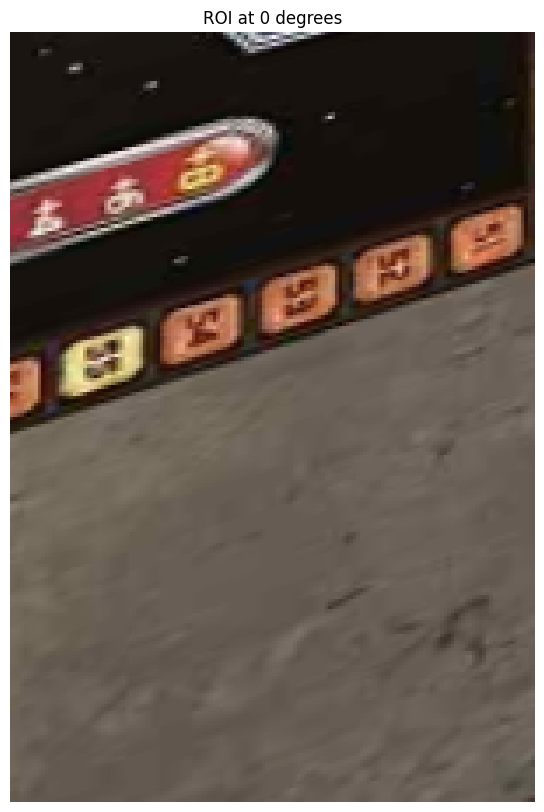

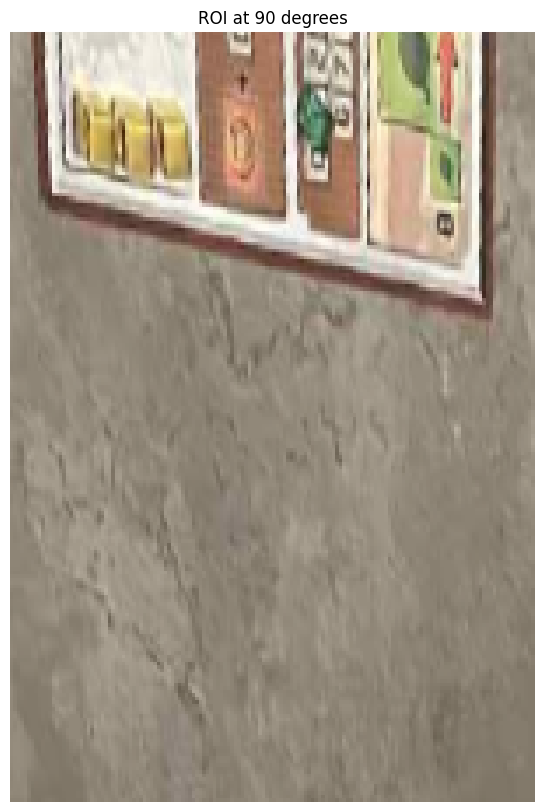

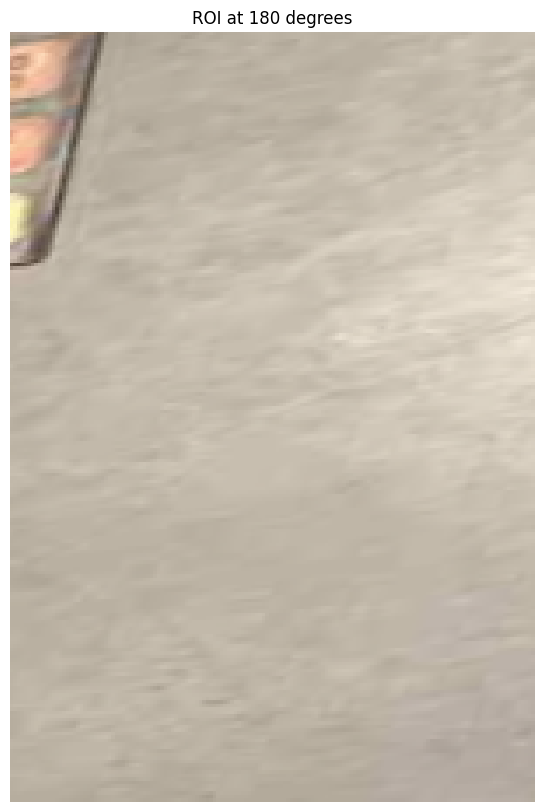

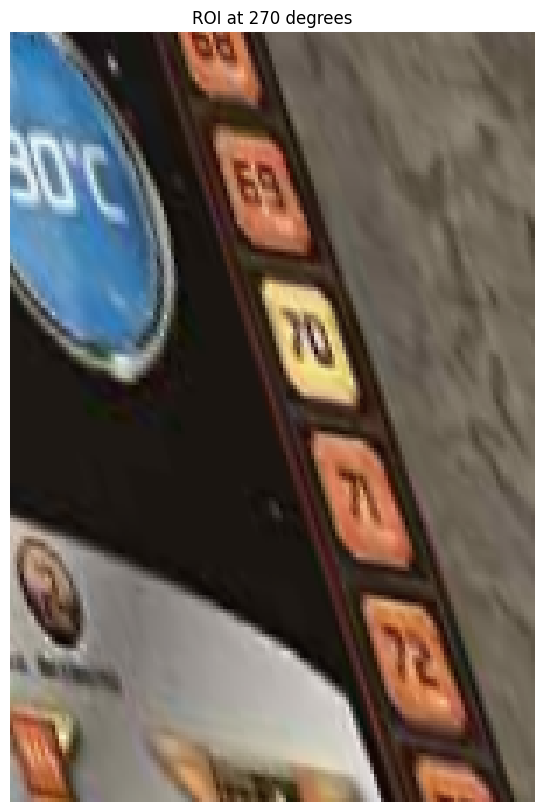

Auto-Rotation applied: 270 degrees (Score: 2688)


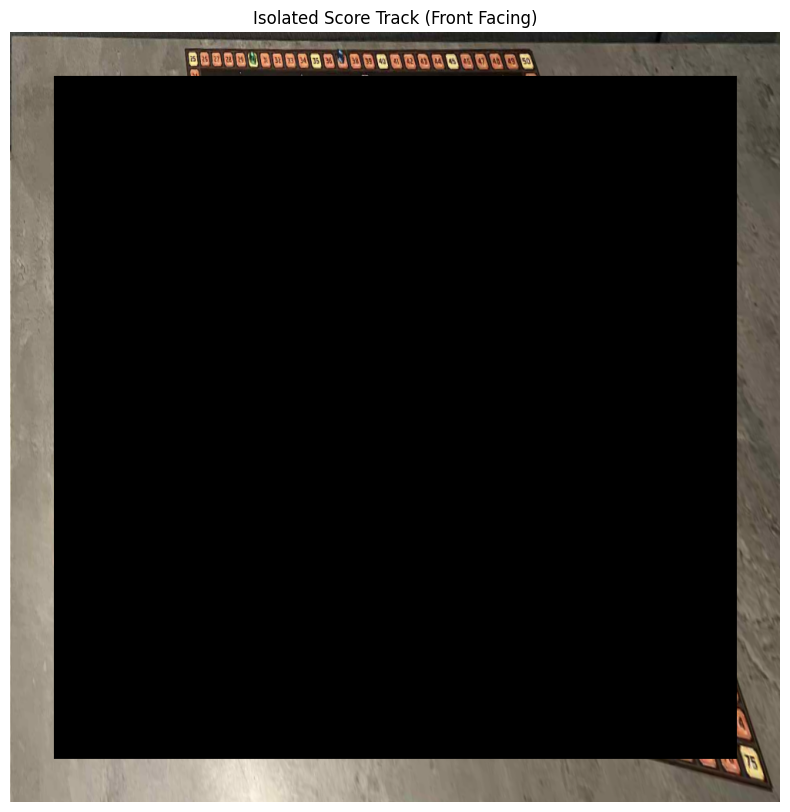

In [2]:
import cv2
import numpy as np

def order_points(pts):
    """Standardizes the order of points: TL, TR, BR, BL"""
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)] # Top-Left
    rect[2] = pts[np.argmax(s)] # Bottom-Right
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)] # Top-Right
    rect[3] = pts[np.argmax(diff)] # Bottom-Left
    return rect

def auto_correct_orientation(img):
    """
    Rotates the board so the Thermometer (Blue/Red strip) is at the bottom.
    Heuristic: The -30C zone is BLUE and should be at the Bottom-Left of the inner map.
    """
    best_img = img
    max_score = -1
    best_angle = 0
    
    # Define the ROI where we expect the Blue -30C marker
    # Relative to a 1000x1000 board: 
    # Y: 85% to 95% (Bottom edge)
    # X: 20% to 40% (Left side of the bottom bar)
    h, w = img.shape[:2]
    roi_y1, roi_y2 = int(h * 0.62), int(h * 0.84)
    roi_x1, roi_x2 = int(w * 0.80), int(w * 0.95)
    
    # Check all 4 rotations
    for angle in [0, 90, 180, 270]:
        rotated = img.copy()
        if angle == 90:
            rotated = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        elif angle == 180:
            rotated = cv2.rotate(img, cv2.ROTATE_180)
        elif angle == 270:
            rotated = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
            
        # Extract the probe region (The spot where -30C should be)
        roi = rotated[roi_y1:roi_y2, roi_x1:roi_x2]
        show_inline(roi, f"ROI at {angle} degrees")  # Debug
        # Convert to HSV to detect Blue
        hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
        
        # Blue Mask (Hue 100-130)
        lower_blue = np.array([90, 50, 50])
        upper_blue = np.array([130, 255, 255])
        mask = cv2.inRange(hsv_roi, lower_blue, upper_blue)
        
        # Score is the number of blue pixels
        score = cv2.countNonZero(mask)
        
        # print(f"Angle {angle}: Blue Score = {score}") # Debug
        
        if score > max_score:
            max_score = score
            best_img = rotated
            best_angle = angle

    print(f"Auto-Rotation applied: {best_angle} degrees (Score: {max_score})")
    return best_img

def isolate_score_track(img, board_contour):
    if img is None or board_contour is None:
        print("Missing input data.")
        return None, None

    # --- 1. Perspective Transform (Flatten) ---
    rect = order_points(board_contour.reshape(4, 2))
    warped_size = 1000
    dst = np.array([
        [0, 0],
        [warped_size - 1, 0],
        [warped_size - 1, warped_size - 1],
        [0, warped_size - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(img, M, (warped_size, warped_size))
    
    # --- 2. Auto-Rotate to Face Front ---
    # This fixes the orientation before we mask the rim
    warped = auto_correct_orientation(warped)

    # --- 3. Calculate the Rim Mask ---
    # Ratio of Inner Map to Total Board ~ 46/52 (approx)
    inner_ratio = 46 / 52
    margin_percentage = (1.0 - inner_ratio) / 2.0
    margin_px = int(warped_size * margin_percentage)

    mask = np.zeros((warped_size, warped_size), dtype="uint8")
    
    # White Box = Keep everything
    cv2.rectangle(mask, (0, 0), (warped_size, warped_size), 255, -1)
    
    # Black Box = Remove Inner Map
    cv2.rectangle(mask,
                  (margin_px, margin_px),
                  (warped_size - margin_px, warped_size - margin_px),
                  0, -1)

    # Apply Mask
    track_only = cv2.bitwise_and(warped, warped, mask=mask)

    show_inline(track_only, f"Isolated Score Track (Front Facing)")
    
    return track_only, warped

# EXECUTE
score_track_img, map_flat = isolate_score_track(img_res, map_cnt)

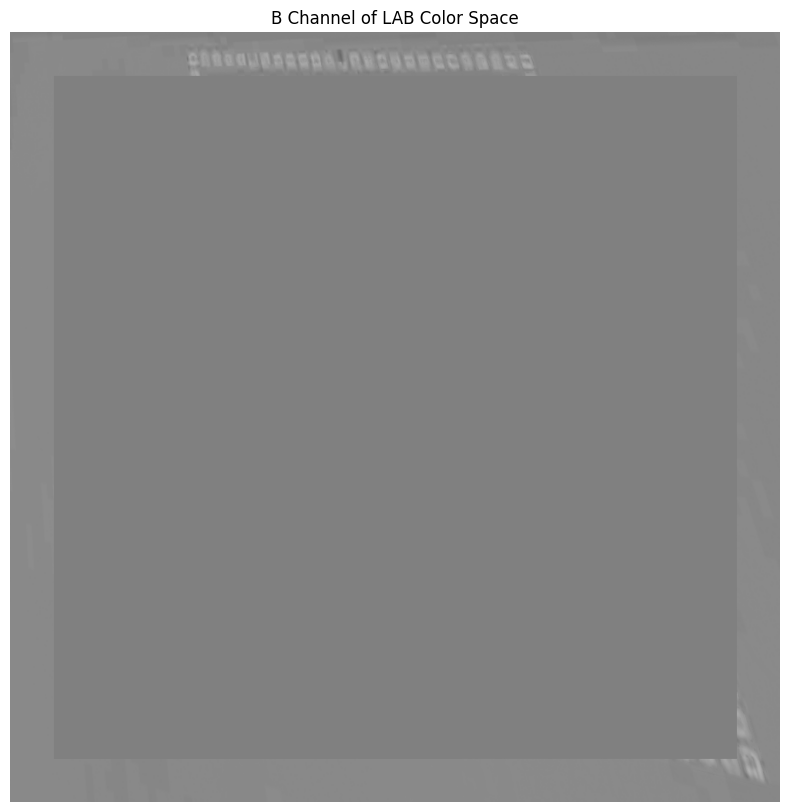

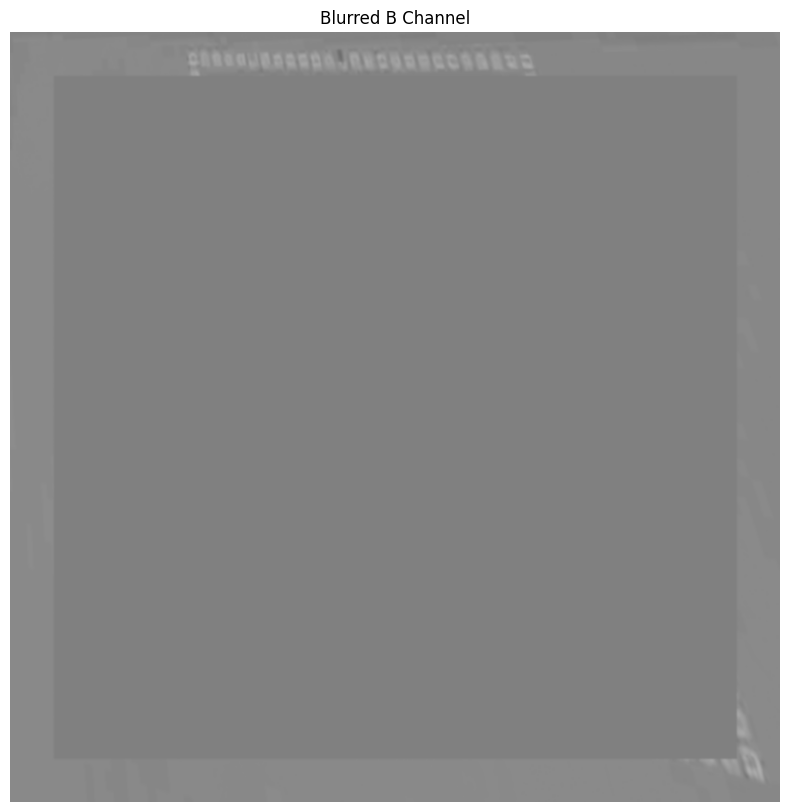

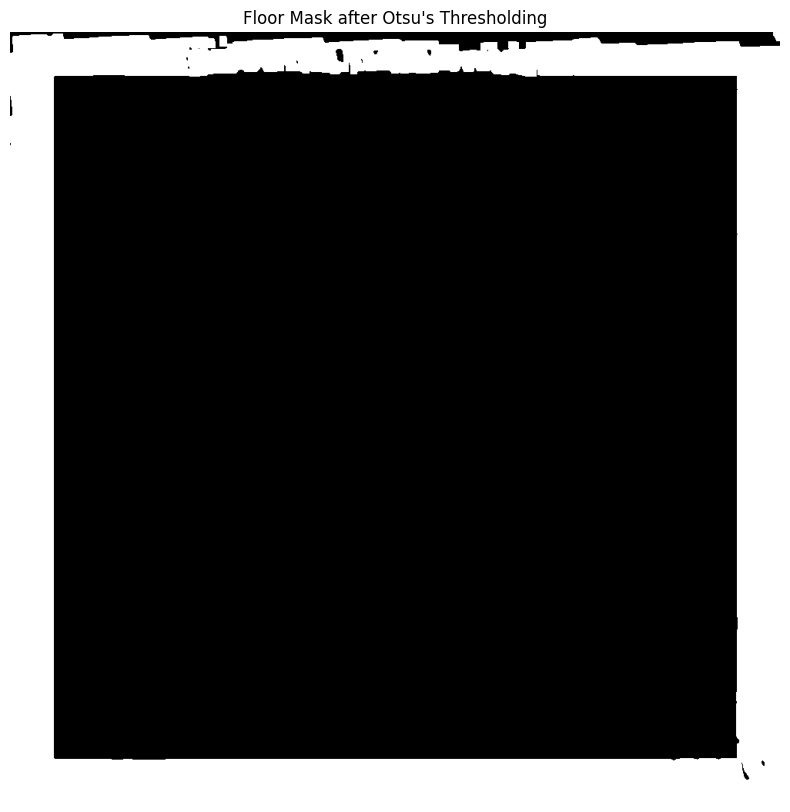

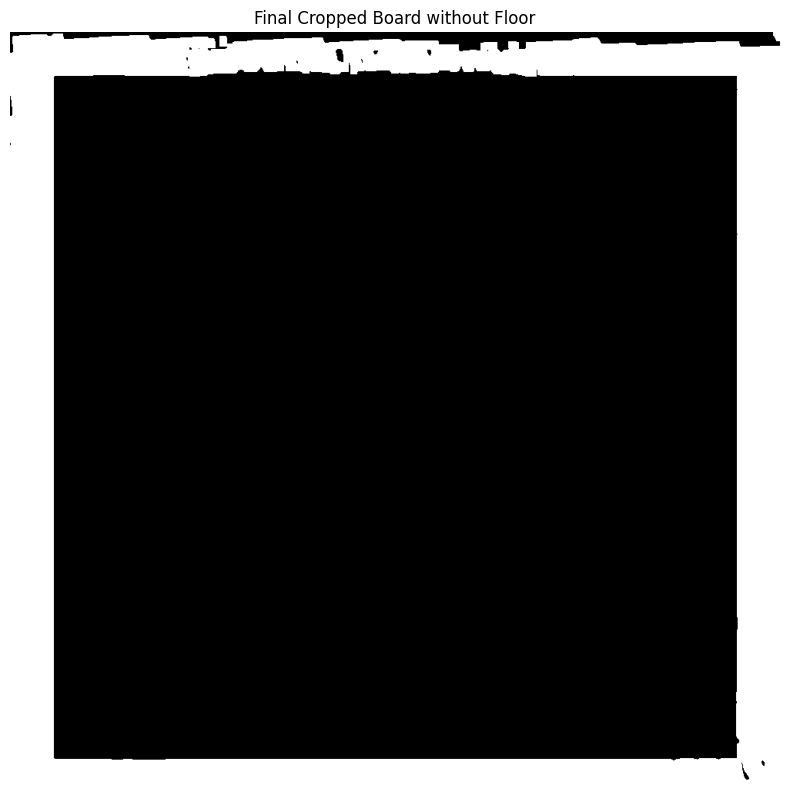

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt # Using plt for better inline visualization

def crop_floor_by_lab(image):
    if image is None: return None
    
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    b_channel = lab[:, :, 2] # The 'B' channel (Yellow strength)
    show_inline(b_channel, "B Channel of LAB Color Space")
    blur = cv2.GaussianBlur(b_channel, (5, 5), 0)
    show_inline(blur, "Blurred B Channel")
    _, mask = cv2.threshold(blur, 0, 255,cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    
    show_inline(mask, "Floor Mask after Otsu's Thresholding") 
    return mask
        
# Unpack the tuple: img is the first item, _ ignores the rest

perfect_board = crop_floor_by_lab(score_track_img)
show_inline(perfect_board, "Final Cropped Board without Floor")


Stats -> Pad Size: 505.0 | Pitch (Pad+Gap): 700.0


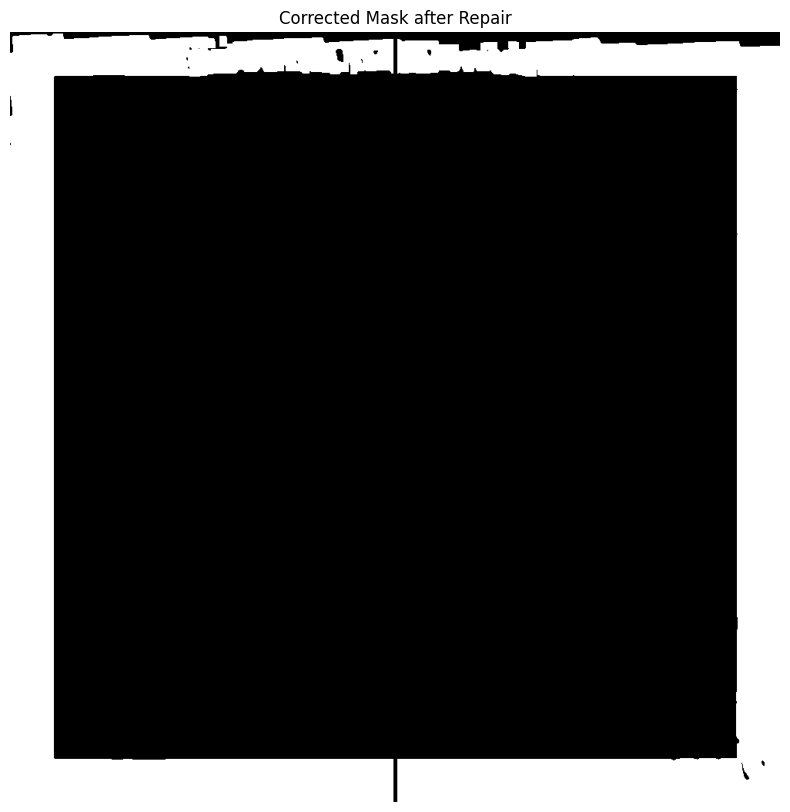

In [4]:
import cv2
import numpy as np

def refine_mask(mask):
    """
    Cleans noise and splits merged pads using 'Pitch' (Pad + Gap) 
    instead of just Pad width to prevent over-splitting.
    """
    # 1. Morphological Open to clean
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # 2. Gather Statistics
    contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter valid contours (ignore tiny noise for stats)
    valid_contours = [c for c in contours if cv2.contourArea(c) > 30]
    
    if not valid_contours:
        print("No contours found.")
        return opened

    # Get basic rects and centroids
    rects = []
    centers = []
    for c in valid_contours:
        x, y, w, h = cv2.boundingRect(c)
        rects.append((x, y, w, h))
        centers.append([x + w//2, y + h//2])

    # A. Calculate Median Side (Pad Width)
    all_dims = [r[2] for r in rects] + [r[3] for r in rects]
    median_side = np.median(all_dims)
    median_area = np.median([r[2]*r[3] for r in rects])

    # B. Calculate Median Pitch (Pad Center to Neighbor Center) -> The Fix!
    centers = np.array(centers)
    if len(centers) > 1:
        # Brute force distance to find nearest neighbor for every pad
        # (Computes distance from every pad to every other pad)
        diffs = centers[:, np.newaxis, :] - centers[np.newaxis, :, :]
        dists = np.sqrt(np.sum(diffs**2, axis=-1))
        
        # Mask the distance to itself (0.0) with infinity
        np.fill_diagonal(dists, np.inf)
        
        # Get min distance for each pad (distance to nearest neighbor)
        nearest_dists = np.min(dists, axis=1)
        median_pitch = np.median(nearest_dists)
    else:
        # Fallback if only 1 pad exists
        median_pitch = median_side * 1.2 

    print(f"Stats -> Pad Size: {median_side:.1f} | Pitch (Pad+Gap): {median_pitch:.1f}")

    # 3. Process & Split
    final_mask = opened.copy()
    
    for c in valid_contours:
        area = cv2.contourArea(c)
        x, y, w, h = cv2.boundingRect(c)
        
        # --- DELETE TOO SMALL ---
        if area < 0.45 * median_area:
            cv2.drawContours(final_mask, [c], -1, 0, -1)
            continue
            
        # --- SPLIT TOO LARGE ---
        # We assume a blob is merged if it's significantly larger than 1 pad
        # We compare against median_side for the trigger, but use PITCH for the count
        if area > 1.5 * median_area:
            
            # Decide split direction
            if w > h: 
                # Horizontal split
                # Use Pitch to calculate count (handles gaps correctly)
                count = int(round(w / median_pitch))
                count = max(2, count)
                
                step = w / count
                for i in range(1, count):
                    split_x = int(x + (i * step))
                    cv2.line(final_mask, (split_x, y), (split_x, y+h), 0, thickness=4)
                    
            else:
                # Vertical split
                count = int(round(h / median_pitch))
                count = max(2, count)
                
                step = h / count
                for i in range(1, count):
                    split_y = int(y + (i * step))
                    cv2.line(final_mask, (x, split_y), (x+w, split_y), 0, thickness=4)

    return final_mask

# --- Usage ---
cleaned_mask = refine_mask(perfect_board)
show_inline(cleaned_mask, "Corrected Mask after Repair")

Repaired 0 missing pads based on 100-count constraint.


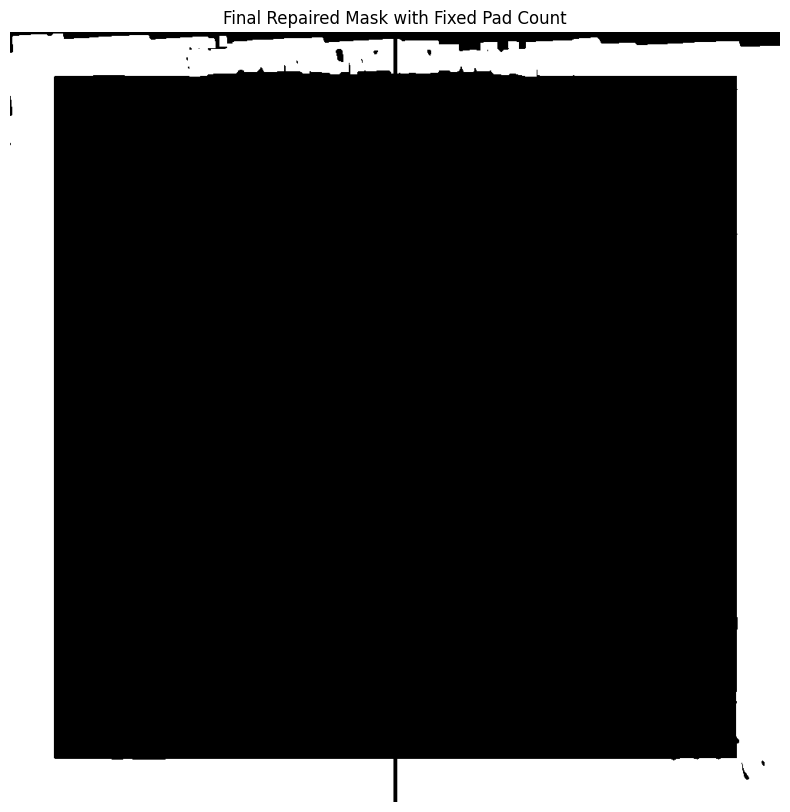

In [5]:
import cv2
import numpy as np

def repair_mask_fixed_count(image_path_or_array, total_pads=100):
    """
    Repairs a square pad mask by enforcing a strict count of pads.
    For 100 total pads, it enforces 26 pads per side (corner-to-corner).
    """
    # 1. Load and Preprocess
    if isinstance(image_path_or_array, str):
        img = cv2.imread(image_path_or_array, cv2.IMREAD_GRAYSCALE)
    else:
        img = image_path_or_array

    # Clean binary mask
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    repaired_mask = thresh.copy()
    
    # Create a color debug image to verify contours are separate
    debug_vis = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

    # 2. Find Contours of EXISTING pads
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    pad_rects = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        # Filter tiny noise
        if w * h > 50:
            pad_rects.append({'cx': x + w//2, 'cy': y + h//2, 'w': w, 'h': h})

    if not pad_rects:
        return img, debug_vis

    # 3. Calculate Geometry Stats
    median_w = int(np.median([p['w'] for p in pad_rects]))
    median_h = int(np.median([p['h'] for p in pad_rects]))
    
    # Find Global Bounds (The 4 Rails)
    all_x = [p['cx'] for p in pad_rects]
    all_y = [p['cy'] for p in pad_rects]
    
    # We define the rails using the median of the pads on the extreme edges
    min_x_bound, max_x_bound = min(all_x), max(all_x)
    min_y_bound, max_y_bound = min(all_y), max(all_y)
    tol_x = (max_x_bound - min_x_bound) * 0.15
    tol_y = (max_y_bound - min_y_bound) * 0.15

    # Filter groups to get precise Rail Coordinates
    left_pads   = [p['cx'] for p in pad_rects if abs(p['cx'] - min_x_bound) < tol_x]
    right_pads  = [p['cx'] for p in pad_rects if abs(p['cx'] - max_x_bound) < tol_x]
    top_pads    = [p['cy'] for p in pad_rects if abs(p['cy'] - min_y_bound) < tol_y]
    bottom_pads = [p['cy'] for p in pad_rects if abs(p['cy'] - max_y_bound) < tol_y]

    rail_left   = int(np.median(left_pads))
    rail_right  = int(np.median(right_pads))
    rail_top    = int(np.median(top_pads))
    rail_bottom = int(np.median(bottom_pads))

    # 4. Define the 4 Perfect Corners (Intersection of Rails)
    tl = (rail_left,  rail_top)
    tr = (rail_right, rail_top)
    br = (rail_right, rail_bottom)
    bl = (rail_left,  rail_bottom)

    # 5. Generate Theoretical Positions
    # Formula: Total = 4 * (N - 1). For Total=100, N=26.
    pads_per_side = int(total_pads / 4) + 1 
    
    ideal_points = []

    def get_linspace(start_pt, end_pt, count):
        """Generates 'count' points from start to end inclusive."""
        pts = []
        for i in range(count):
            t = i / (count - 1)
            x = int(start_pt[0] + (end_pt[0] - start_pt[0]) * t)
            y = int(start_pt[1] + (end_pt[1] - start_pt[1]) * t)
            pts.append((x, y))
        return pts

    # Generate points for all 4 sides
    # We slice the lists to avoid adding the corners multiple times
    
    # Top: TL -> TR (All 26 points)
    ideal_points.extend(get_linspace(tl, tr, pads_per_side))
    
    # Right: TR -> BR (Skip first, as it is TR)
    ideal_points.extend(get_linspace(tr, br, pads_per_side)[1:])
    
    # Bottom: BR -> BL (Skip first, as it is BR)
    ideal_points.extend(get_linspace(br, bl, pads_per_side)[1:])
    
    # Left: BL -> TL (Skip first (BL) and last (TL))
    ideal_points.extend(get_linspace(bl, tl, pads_per_side)[1:-1])

    # 6. Draw Missing Pads
    # We iterate through our "Perfect 100" list. 
    # If a pad exists there, we do nothing. If not, we draw.
    
    pads_drawn = 0
    
    for (ix, iy) in ideal_points:
        # Check if an existing pad is close to this ideal point
        # "Close" = within half a pad's width
        match_found = False
        for p in pad_rects:
            dist = abs(p['cx'] - ix) + abs(p['cy'] - iy) # Manhattan dist is faster
            if dist < (median_w / 2 + median_h / 2):
                match_found = True
                break
        
        if not match_found:
            # Draw NEW pad
            # We use median_w and median_h to ensure they look like the others
            # We draw slightly smaller (minus 2 pixels) to ensure visual separation if they are tight
            draw_w = median_w - 2
            draw_h = median_h - 2
            
            tl_x = int(ix - draw_w // 2)
            tl_y = int(iy - draw_h // 2)
            
            cv2.rectangle(repaired_mask, (tl_x, tl_y), (tl_x + draw_w, tl_y + draw_h), 255, -1)
            
            # Debug visual (Green for filled pads)
            cv2.rectangle(debug_vis, (tl_x, tl_y), (tl_x + draw_w, tl_y + draw_h), (0, 255, 0), -1)
            pads_drawn += 1

    print(f"Repaired {pads_drawn} missing pads based on {total_pads}-count constraint.")
    return repaired_mask, debug_vis

final_mask, debug_view = repair_mask_fixed_count(cleaned_mask, total_pads=100)
show_inline(final_mask, "Final Repaired Mask with Fixed Pad Count")

In [6]:
#

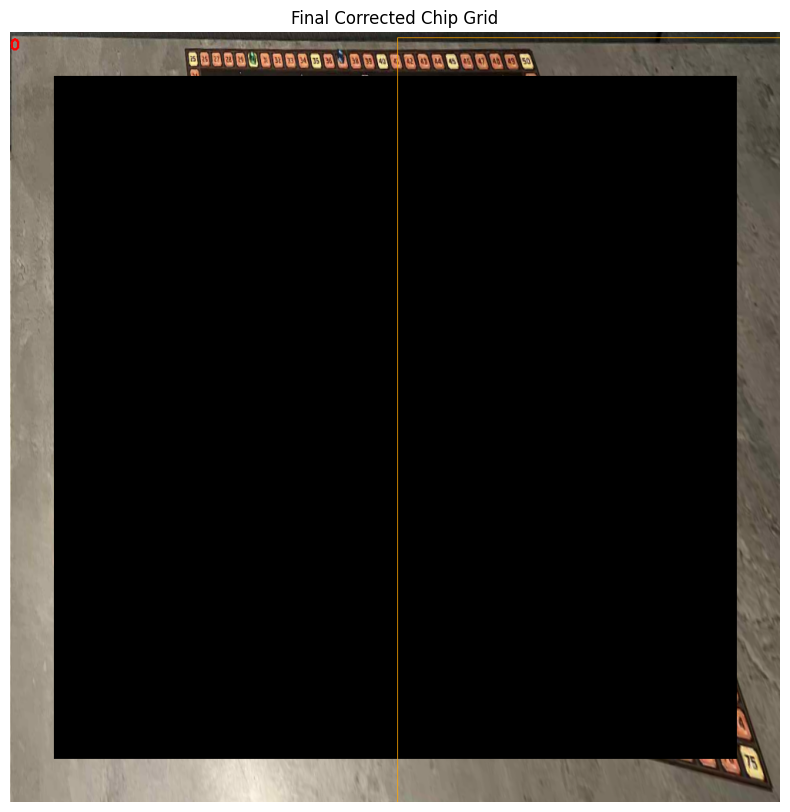

In [7]:
import cv2
import numpy as np
import math

def process_chip_grid(original_img_path, mask_img_path):
     original = original_img_path
     vis = original.copy()
     mask = mask_img_path
     _, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
     contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
     
     pads = []
     for c in contours:
         x, y, w, h = cv2.boundingRect(c)
         if w * h > 50: 
            pads.append({'x': x, 'y': y, 'w': w, 'h': h, 'cx': x + w//2, 'cy': y + h//2, 'real': True})
     if pads:
         pads.sort(key=lambda p: p['cx']) 
         med_w = np.median([p['w'] for p in pads])
         med_h = np.median([p['h'] for p in pads])
     all_cx = [p['cx'] for p in pads]
     all_cy = [p['cy'] for p in pads]
     grid_cx = np.mean(all_cx)
     grid_cy = np.mean(all_cy)
     for p in pads:
         p['angle'] = math.atan2(p['cy'] - grid_cy, p['cx'] - grid_cx)
     pads.sort(key=lambda p: p['angle'])
     dist_to_tl = [p['cx'] + p['cy'] for p in pads]
     start_index = np.argmin(dist_to_tl)
     ordered_pads = pads[start_index:] + pads[:start_index]
     yellow_group = []
     orange_group = []
     for i, p in enumerate(ordered_pads):
         x, y, w, h = p['x'], p['y'], p['w'], p['h']
         is_yellow = (i % 5 == 0)
         if is_yellow:
             yellow_group.append(p)
             color = (0, 255, 255) 
             thick = 3
             roi = original[y:y+h, x:x+w]
             mean_color = np.mean(roi, axis=(0,1))
         else:
             orange_group.append(p)
             color = (0, 165, 255) 
             thick = 1
             cv2.rectangle(vis, (x, y), (x+w, y+h), color, thick)
         if is_yellow:
          cv2.putText(vis, str(i), (x, y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

 
     return vis, ordered_pads

result_img, pad_data = process_chip_grid(score_track_img, final_mask)
cv2.imwrite('final_corrected_sort.png', result_img)
show_inline(result_img, "Final Corrected Chip Grid")


--- Top 2 Anomalies ---


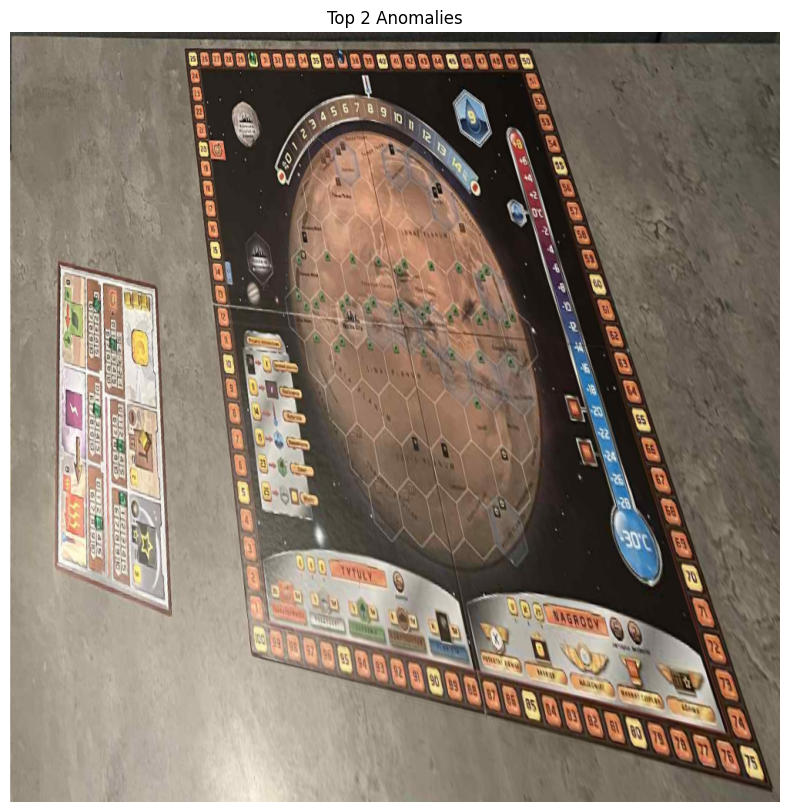

In [8]:
import cv2
import numpy as np
import math

def detect_anomalies_top_n(original_img, pad_data, period=5, neighbor_count=3, top_n=5):
    """
    Calculates deviation scores for all pads and returns the 'top_n' most likely anomalies.
    """
    yellow_neighbor_count= neighbor_count - 1
    orange_neighbor_count= neighbor_count
    vis = original_img.copy()
    
    # 1. Compute Color Stats for every pad
    for p in pad_data:
        x, y, w, h = p['x'], p['y'], p['w'], p['h']
        # Extract ROI (Region of Interest)
        roi = original_img[y+2:y+h-2, x+2:x+w-2] # +2 margin to avoid edge noise
        
        if roi.size > 0:
            mean_bgr = np.mean(roi, axis=(0,1))
            # Convert single pixel to HSV
            p['hsv'] = cv2.cvtColor(np.uint8([[mean_bgr]]), cv2.COLOR_BGR2HSV)[0][0]
        else:
            p['hsv'] = np.array([0, 0, 0])

    # 2. Split into Clusters (Yellow vs Orange pattern)
    # Adjust 'period' if your pattern is different (e.g. 1 yellow every 5 pads)
    cluster_yellow = [p for i, p in enumerate(pad_data) if i % period == 0]
    cluster_orange = [p for i, p in enumerate(pad_data) if i % period != 0]

    all_scored_pads = []

    # 3. Local Scoring Function
    def score_cluster(cluster_list,neighbor_count):

        count = len(cluster_list)
        if count < neighbor_count * 2 + 1: return

        for i, pad in enumerate(cluster_list):
            current_color = pad['hsv'].astype(float)
            
            # Collect neighbors (circular buffer style)
            neighbors_hsv = []
            for offset in range(1, neighbor_count + 1):
                prev_idx = (i - offset) % count
                next_idx = (i + offset) % count
                neighbors_hsv.append(cluster_list[prev_idx]['hsv'].astype(float))
                neighbors_hsv.append(cluster_list[next_idx]['hsv'].astype(float))
            
            local_mean = np.mean(neighbors_hsv, axis=0)
            
            # Calculate Differences
            diff_h = abs(current_color[0] - local_mean[0])
            diff_s = abs(current_color[1] - local_mean[1])
            diff_v = abs(current_color[2] - local_mean[2])
            
            # Hue wrap-around fix (179 <-> 0)
            diff_h = min(diff_h, 180 - diff_h)

            # Euclidean Distance in HSV space
            deviation_score = math.sqrt(diff_h**2 + diff_s**2 + diff_v**2)
            
            # Store score in pad and add to master list
            pad['deviation'] = deviation_score
            all_scored_pads.append(pad)

    # 4. Run scoring on both clusters
    score_cluster(cluster_yellow,yellow_neighbor_count)
    score_cluster(cluster_orange,orange_neighbor_count)

    # 5. Sort and Select Top N
    # Sort descending by deviation
    all_scored_pads.sort(key=lambda x: x['deviation'], reverse=True)
    
    top_guesses = all_scored_pads[:top_n]

    # 6. Visualize Top N
    print(f"--- Top {top_n} Anomalies ---")
    for rank, p in enumerate(top_guesses):
        x, y, w, h = p['x'], p['y'], p['w'], p['h']
        score = p['deviation']
        
        print(f"#{rank+1}: Score {score:.2f} at ({x}, {y})")
        
        # Draw Thick Red Box
        cv2.rectangle(vis, (x, y), (x+w, y+h), (0, 0, 255), 3)
        
        # Draw Rank Label (e.g., "#1")
        label = f"#{rank+1} ({int(score)})"
        cv2.putText(vis, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

    return vis, top_guesses

# --- Usage ---
result_img, best_guesses = detect_anomalies_top_n(map_flat, pad_data, top_n=player_num)
show_inline(result_img, f"Top {player_num} Anomalies")

In [9]:
import cv2
import numpy as np

def extract_inner_map(original_img, pad_data):
    """
    Uses the detected grid pads to find the inner bounding box of the map
    and performs a perspective transform to extract a flat, top-down view.
    """
    if not pad_data:
        print("No pad data provided.")
        return original_img

    # 1. Identify the 4 Corner Pads based on geometric extremes
    # (This works even if the board is rotated)
    # TL: Min (x + y), TR: Max (x - y), BR: Max (x + y), BL: Min (x - y)
    
    pad_tl = min(pad_data, key=lambda p: p['x'] + p['y'])
    pad_tr = max(pad_data, key=lambda p: p['x'] - p['y'])
    pad_br = max(pad_data, key=lambda p: p['x'] + p['y'])
    pad_bl = min(pad_data, key=lambda p: p['x'] - p['y'])

    # 2. Define the Inner Corners (The points touching the map)
    # Note: boundingRect is axis-aligned. 
    # TL Pad -> Use its Bottom-Right corner (x+w, y+h)
    src_tl = [pad_tl['x'] + pad_tl['w'], pad_tl['y'] + pad_tl['h']]
    
    # TR Pad -> Use its Bottom-Left corner (x, y+h)
    src_tr = [pad_tr['x'], pad_tr['y'] + pad_tr['h']]
    
    # BR Pad -> Use its Top-Left corner (x, y)
    src_br = [pad_br['x'], pad_br['y']]
    
    # BL Pad -> Use its Top-Right corner (x+w, y)
    src_bl = [pad_bl['x'] + pad_bl['w'], pad_bl['y']]

    src_pts = np.float32([src_tl, src_tr, src_br, src_bl])

    # 3. Calculate Target Dimensions
    # We use the maximum width/height found to keep the aspect ratio correct
    width_top = np.linalg.norm(src_pts[1] - src_pts[0])
    width_btm = np.linalg.norm(src_pts[2] - src_pts[3])
    max_width = int(max(width_top, width_btm))

    height_lft = np.linalg.norm(src_pts[3] - src_pts[0])
    height_rgt = np.linalg.norm(src_pts[2] - src_pts[1])
    max_height = int(max(height_lft, height_rgt))

    # 4. Define Destination Points (A perfect rectangle)
    dst_pts = np.float32([
        [0, 0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1]
    ])

    # 5. Perform the Warp
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped_map = cv2.warpPerspective(original_img, M, (max_width, max_height))

    # Optional: Draw debug lines on original to show what we cropped
    debug_img = original_img.copy()
    cv2.polylines(debug_img, [np.int32(src_pts)], isClosed=True, color=(0, 255, 0), thickness=3)

    return warped_map, debug_img

# --- Usage Example ---
# Assuming 'score_track_img' is your main image and 'pad_data' is from the previous step
final_map, crop_debug = extract_inner_map(map_flat, pad_data)

# Show/Save
cv2.imwrite('final_inner_map.png', final_map)
# show_inline(final_map, "Extracted Inner Map")

# show_inline(crop_debug, "Crop Area Visualization")

True

Successfully extracted 2 player boards.


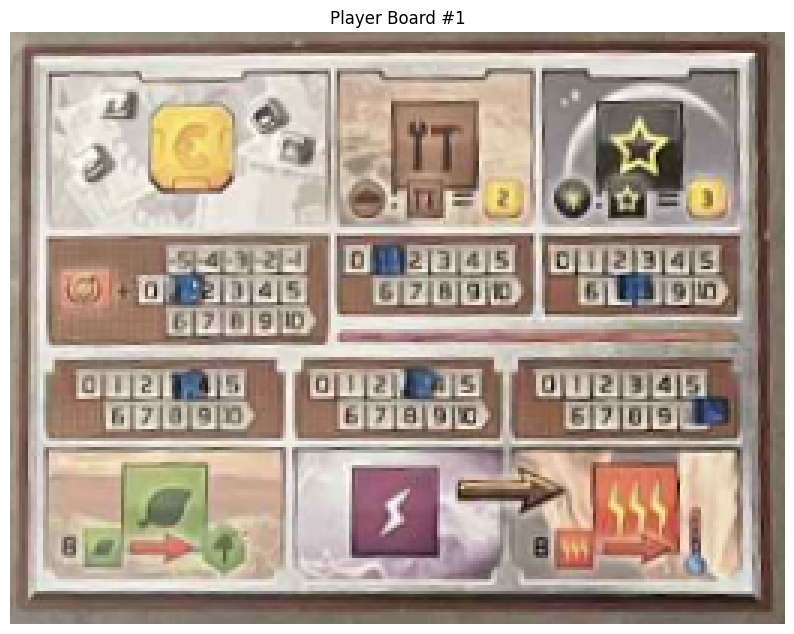

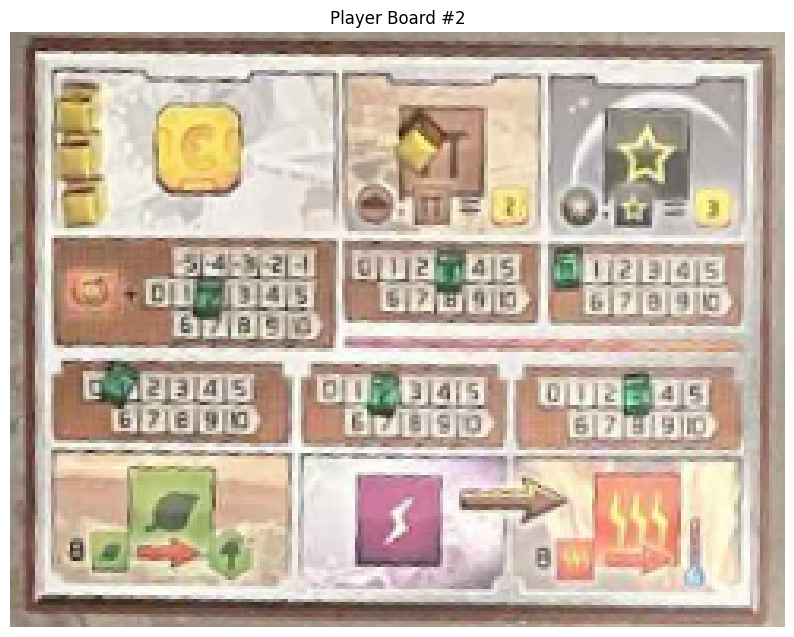

In [10]:
import cv2
import numpy as np

import cv2
import numpy as np

import cv2
import numpy as np

def correct_orientation(image):
    """
    Analyzes the image to find the Purple 'Energy' region.
    Rotates the image so that the Purple region ends up in the 'Bottom-Center'.
    
    Layout Logic:
    - Top Row: Money, Steel, Titanium
    - Bottom Row: Plants, [Purple Energy], Heat
    Therefore, if Purple is at the Bottom, Money is at the Top-Left.
    """
    h, w = image.shape[:2]
    
    # 1. Convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # 2. Define range for Purple
    # OpenCV Hue for Purple is approx 130-160.
    lower_purple = np.array([125, 50, 50])
    upper_purple = np.array([170, 255, 255])
    
    # 3. Create Mask
    mask = cv2.inRange(hsv, lower_purple, upper_purple)
    
    # Clean up noise (remove small dots)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # 4. Find the largest Purple Contour
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        print("Warning: No purple region found. Returning original.")
        return image
        
    # Get the largest blob (The Energy Box)
    largest_cnt = max(contours, key=cv2.contourArea)
    
    # 5. Find the Center (Centroid) of the Purple Box
    M = cv2.moments(largest_cnt)
    if M["m00"] == 0: return image
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    # 6. Determine Rotation based on Position
    # We want the Purple Box to be at the BOTTOM (High Y value)
    
    # Calculate relative position (0.0 to 1.0)
    rel_x = cX / w
    rel_y = cY / h
    
    # Heuristics:
    # If Y is > 0.6, it's already at the bottom.
    # If Y is < 0.4, it's at the top (needs 180 flip).
    # If X is < 0.4 (and Y is mid), it's on the Left (needs 90 CCW).
    # If X is > 0.6 (and Y is mid), it's on the Right (needs 90 CW).
    
    if rel_y > 0.60:
        # Region is at the Bottom. Correct.
        return image
    elif rel_y < 0.40:
        # Region is at the Top. Rotate 180.
        return cv2.rotate(image, cv2.ROTATE_180)
    elif rel_x < 0.40:
        # Region is on the Left. Rotate 90 Counter-Clockwise to bring it to Bottom.
        return cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif rel_x > 0.60:
        # Region is on the Right. Rotate 90 Clockwise to bring it to Bottom.
        return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

    # Fallback if it's perfectly center (unlikely)
    return image

# --- USAGE within your pipeline ---
# Assuming 'warped' is the result of your perspective transform
# oriented_board = correct_orientation_using_black(warped)
# show_inline(oriented_board, "Oriented Board (Money TL)")unctions remain unchanged ---

def order_points(pts):
    # ... (standard implementation as before) ...
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(image, pts):
    # ... (standard implementation as before) ...
    rect = order_points(pts.reshape(4, 2))
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

def get_warped_player_boards(original_img, player_contours):
    warped_images = []
    if original_img is None or not player_contours:
        return warped_images

    for contour in player_contours:
        try:
            # 1. Warp perspective
            warped = four_point_transform(original_img, contour)
            
            # 2. Correct orientation (Now using GREEN as anchor)
            oriented = correct_orientation(warped)
            
            warped_images.append(oriented)
        except Exception as e:
            print(f"Could not warp/rotate a contour: {e}")
            
    return warped_images
player_board_images = get_warped_player_boards(img_res, player_cnts)

# Now 'player_board_images' is a list containing only the board images
print(f"Successfully extracted {len(player_board_images)} player boards.")
for i, board_img in enumerate(player_board_images):
    show_inline(board_img, f"Player Board #{i+1}")


In [11]:
#save empty board for reference
# cv2.imwrite('ref_pb.jpg', player_board_images[0])
ref_board = cv2.imread('ref_pb.jpg')



2-18/44, x 1-11/ 32

2-18/44 x 11-17/32

18-31/44 x 1-11/32

18-31/44 x 11-17/32

31-43/44 x 1-11/32

31-43/44 x 11-17/32

2-16/44 x 23-31/32

2-16/44 x 18-23/32

16-28/44 x 23-31/32

16-28/44 x 18-23/32

29-43/44 x 23-31/32

29-43/44 x 18-23/32

Player 0 Board Segments:


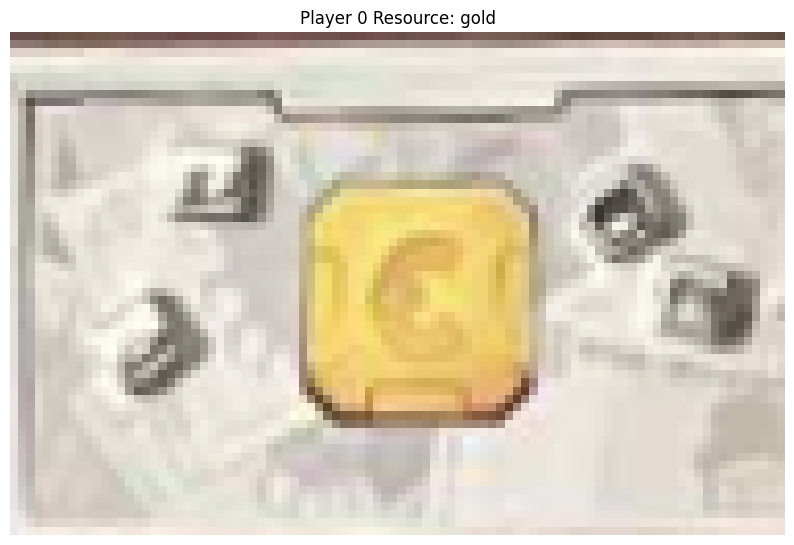

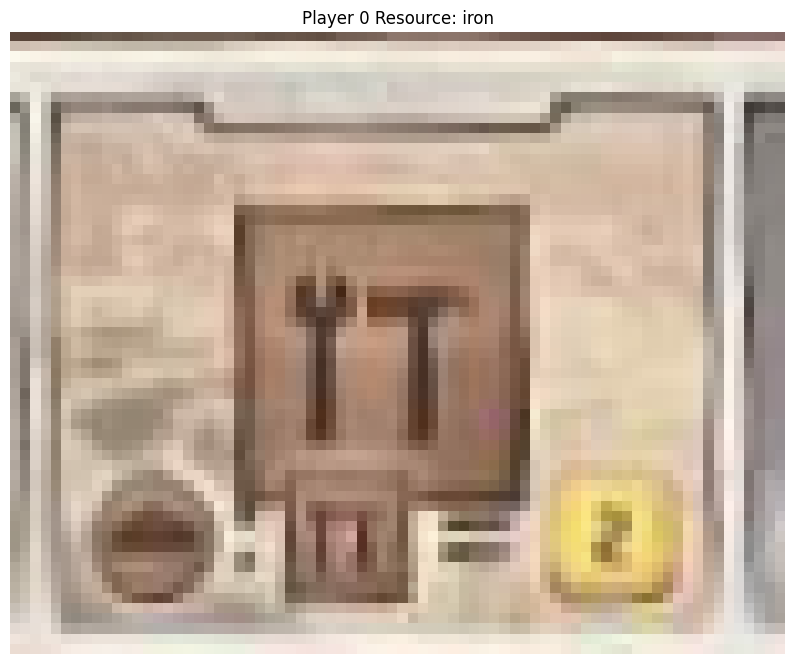

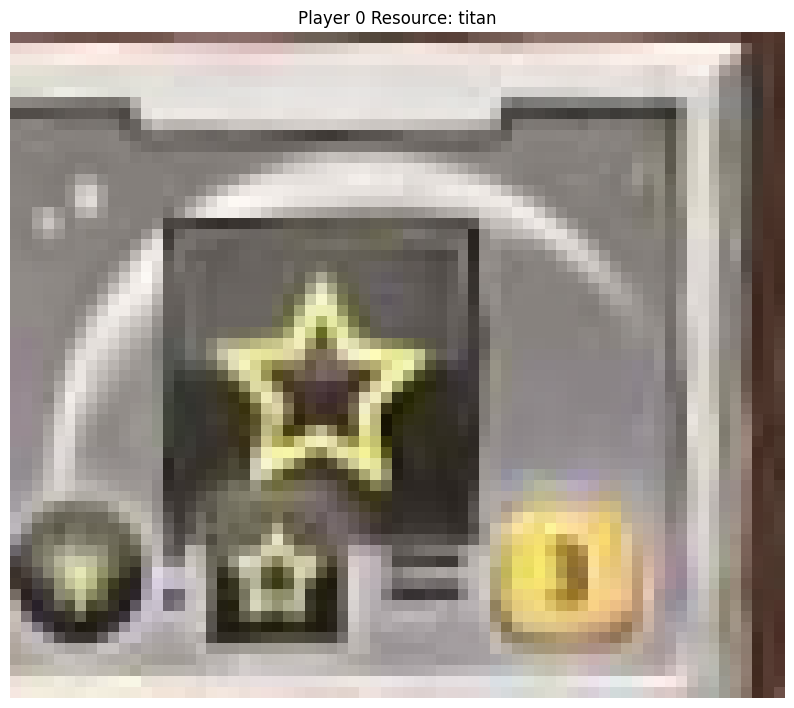

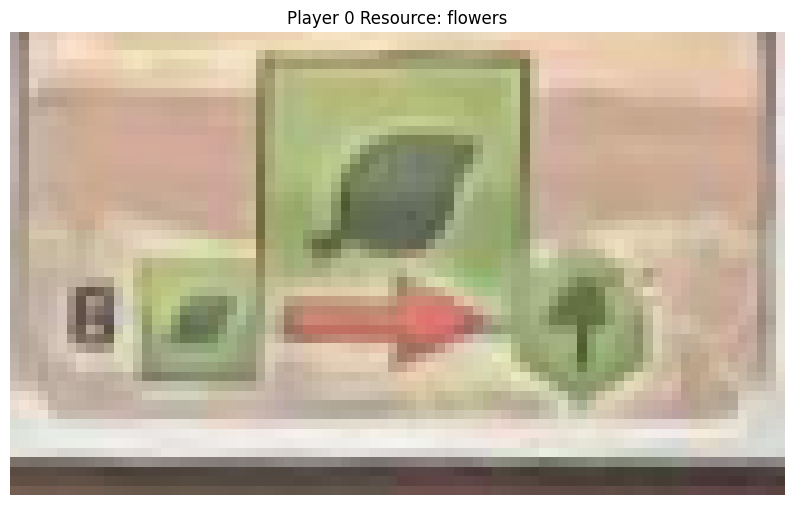

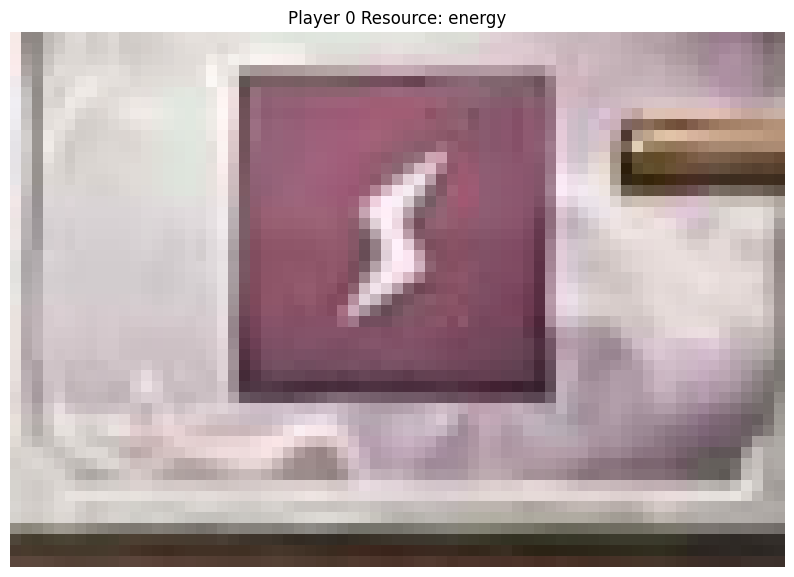

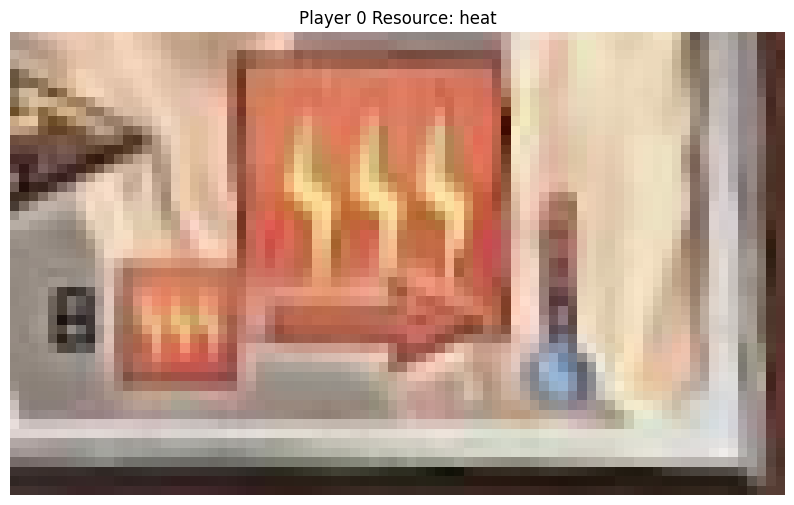

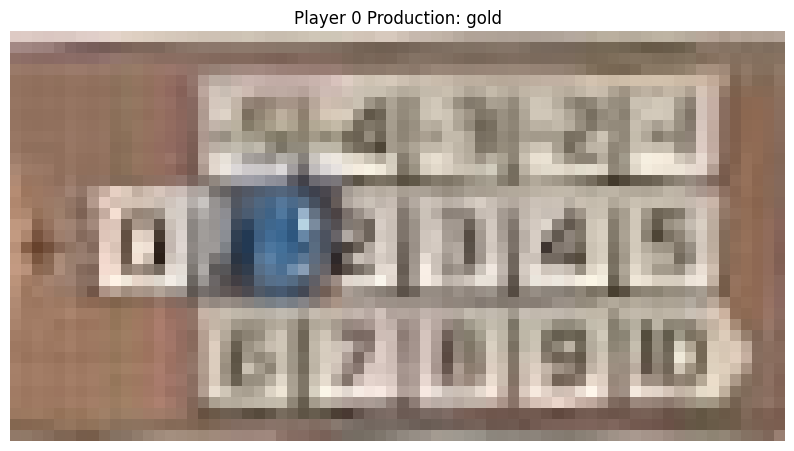

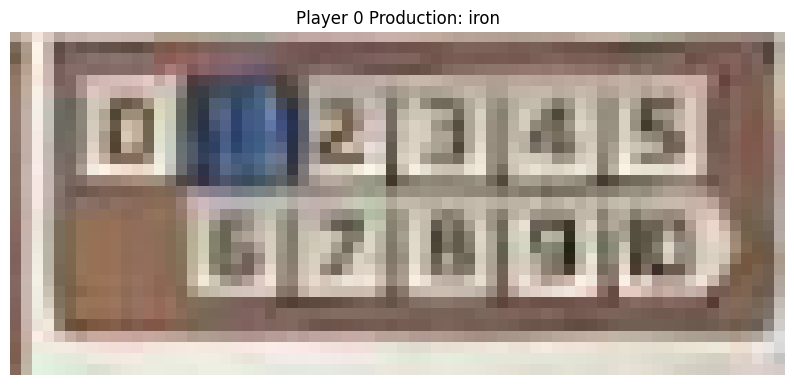

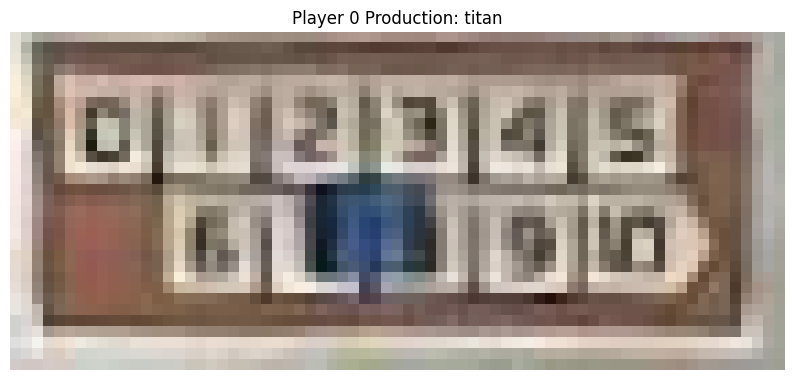

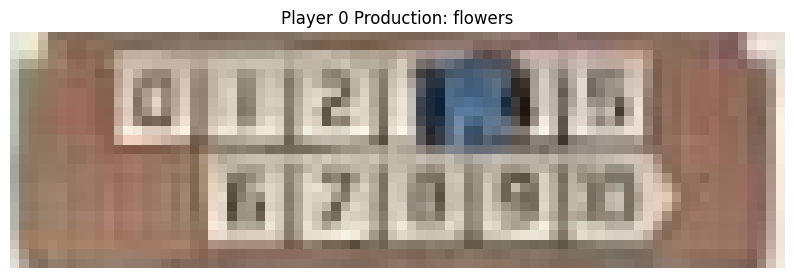

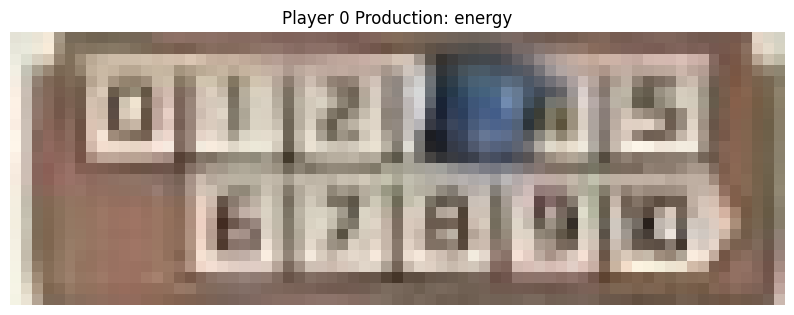

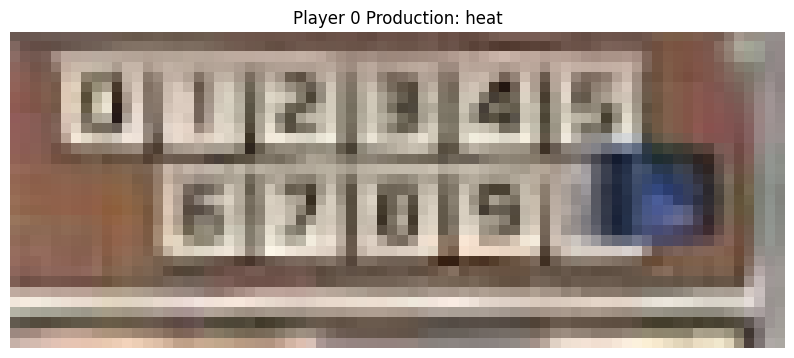

Player 1 Board Segments:


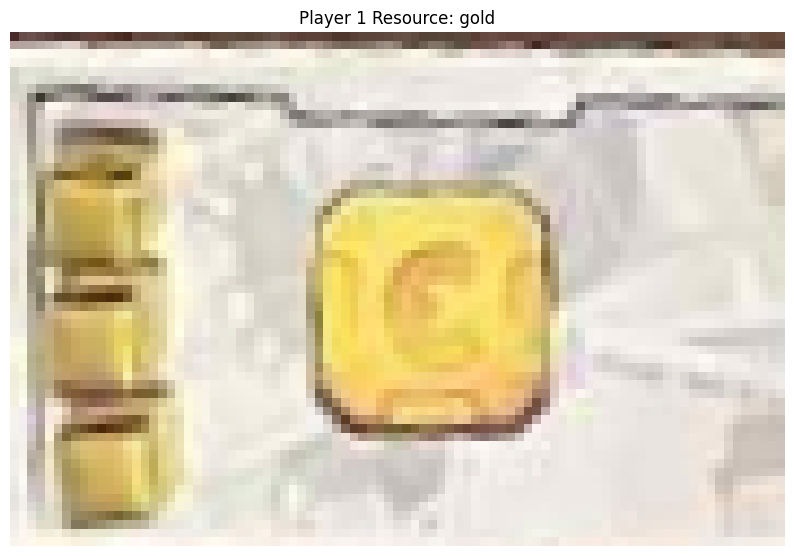

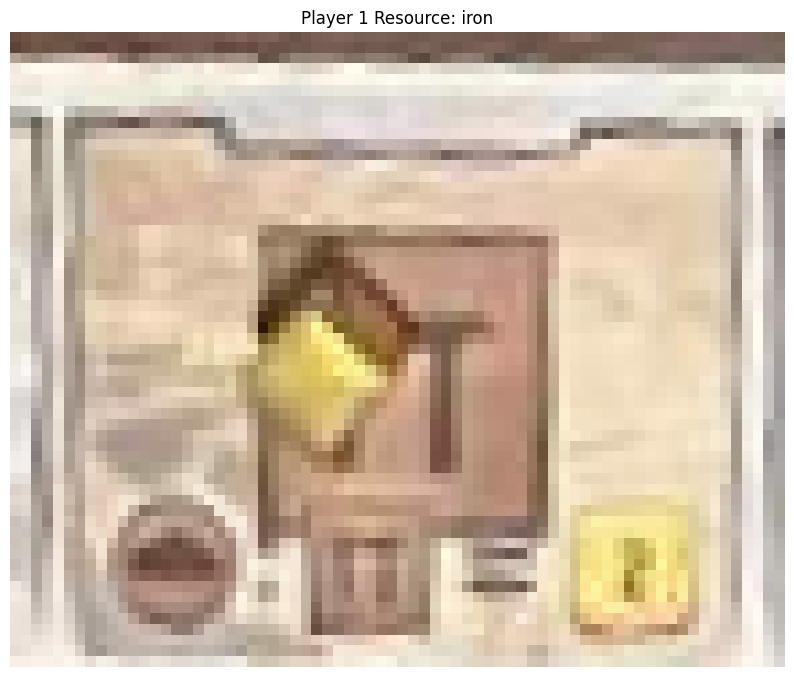

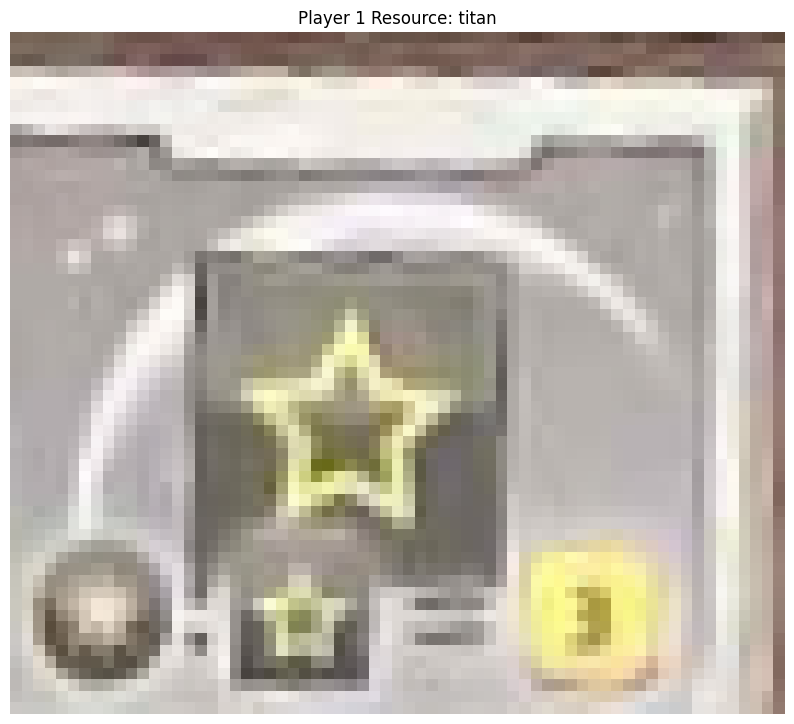

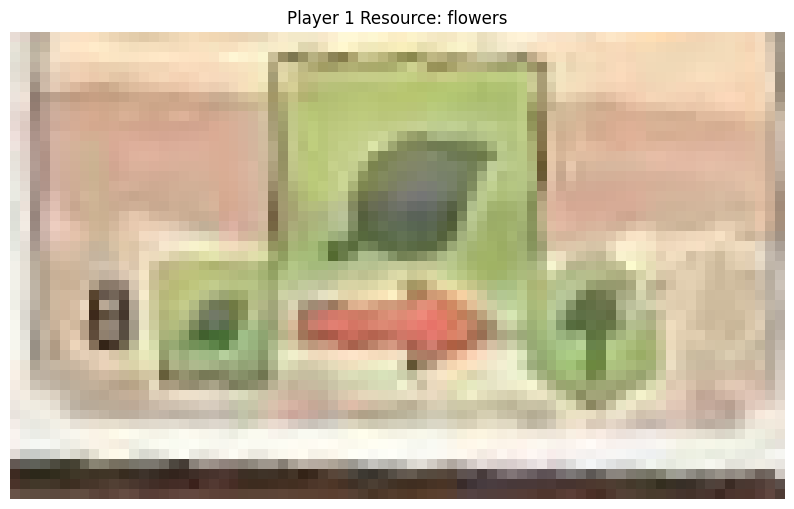

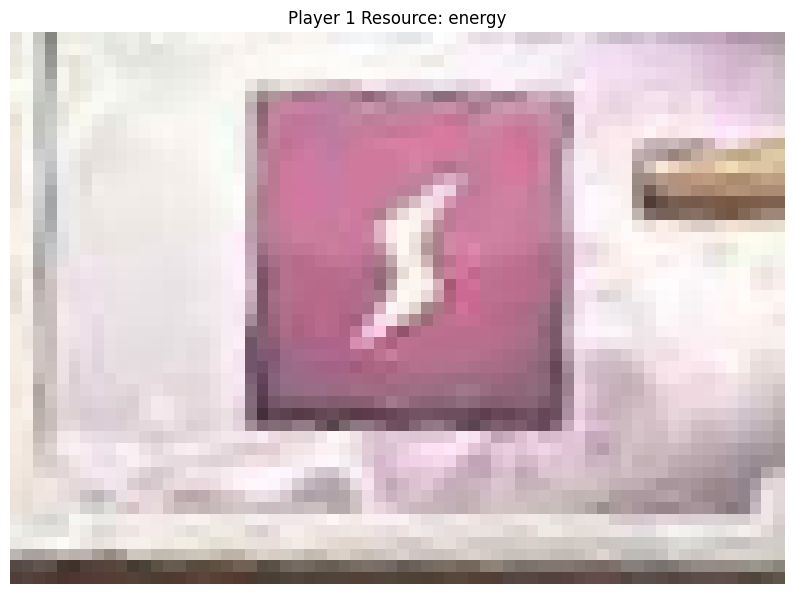

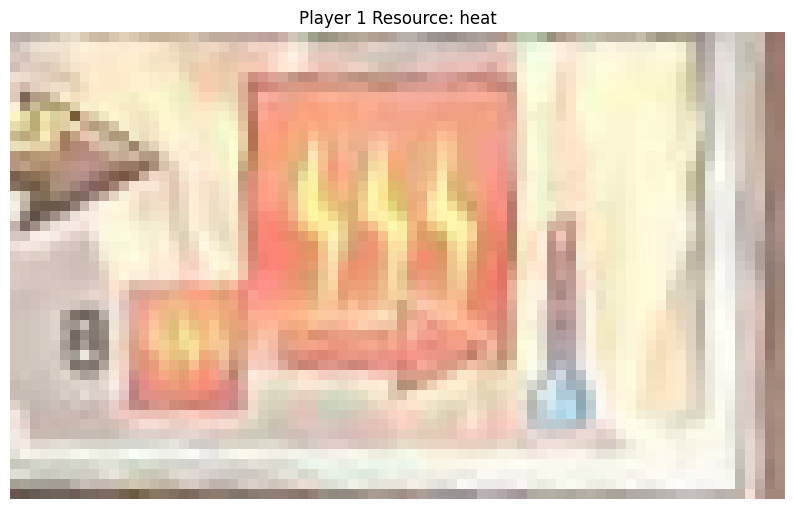

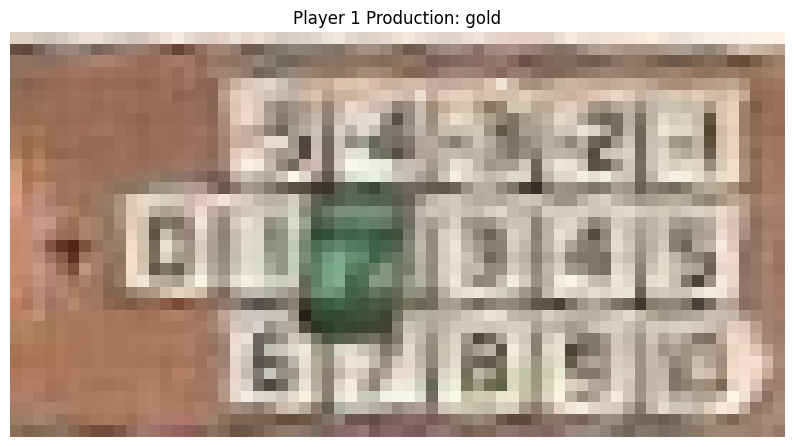

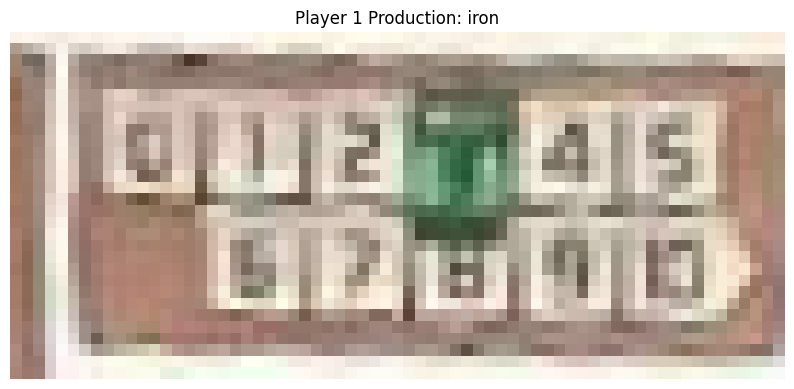

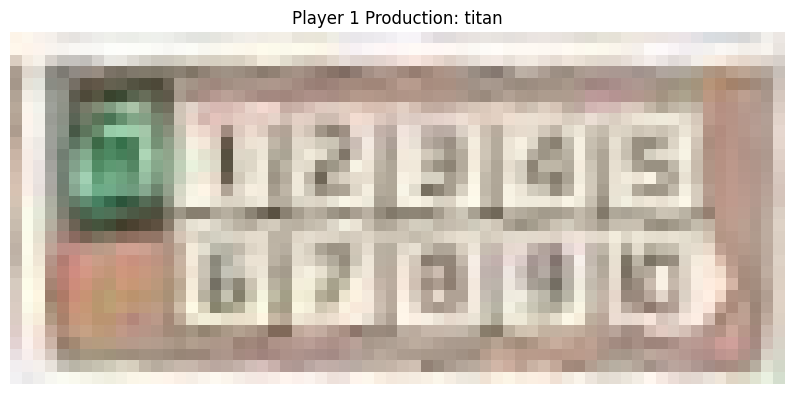

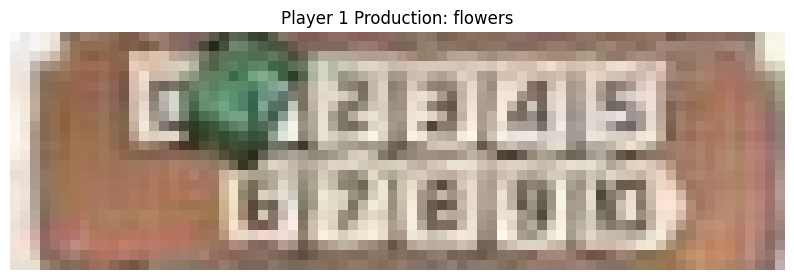

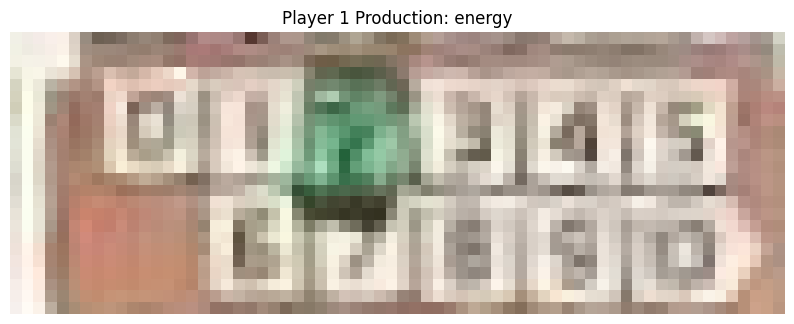

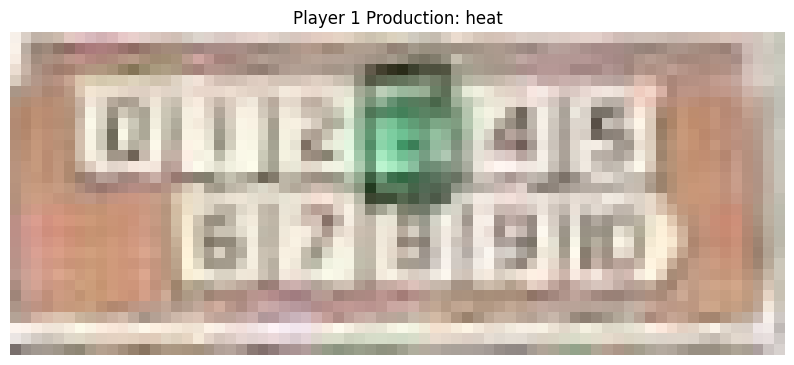

Player -1 Board Segments:


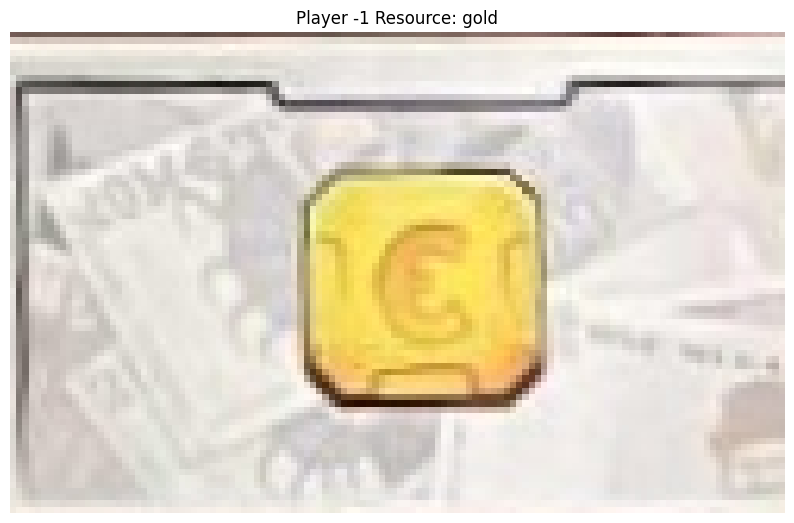

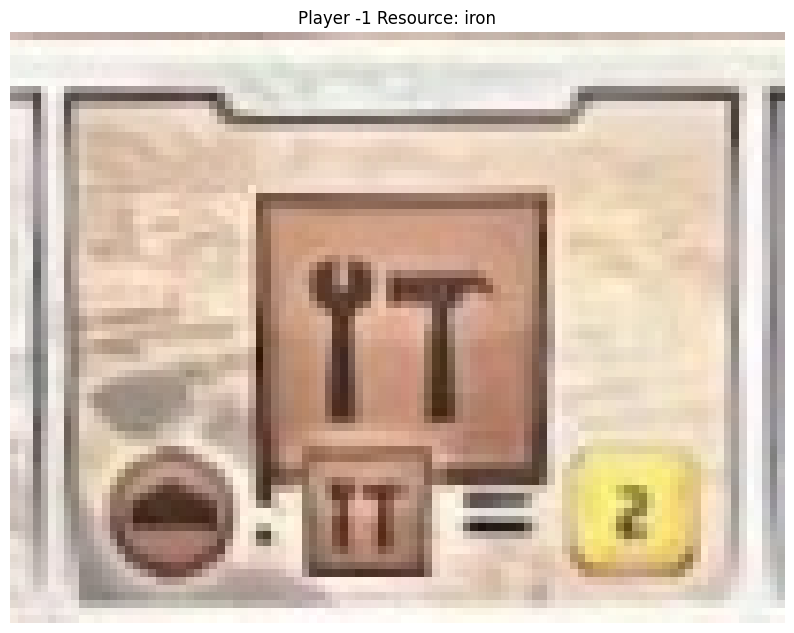

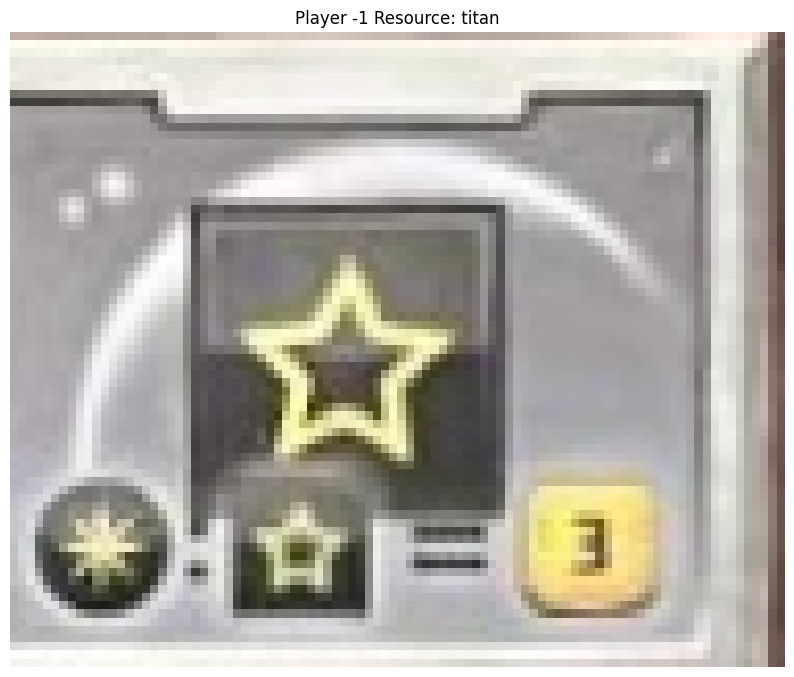

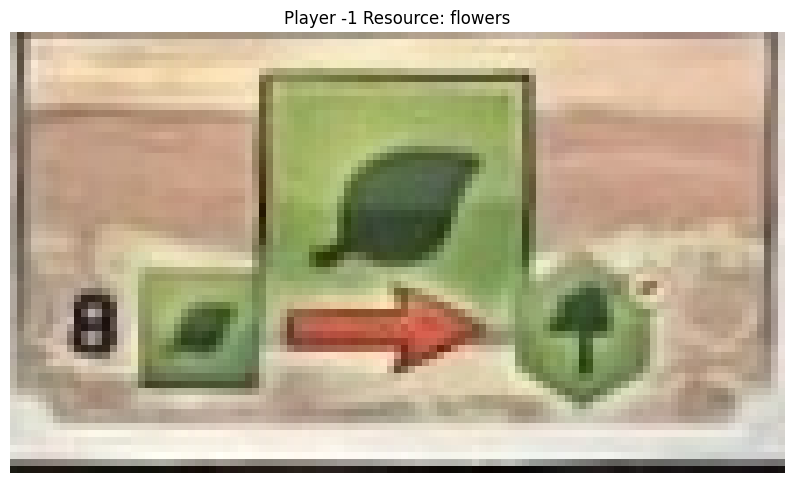

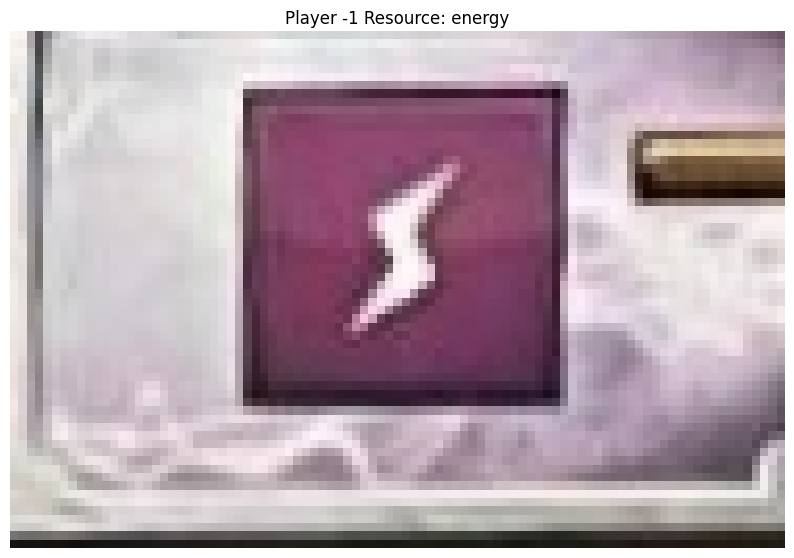

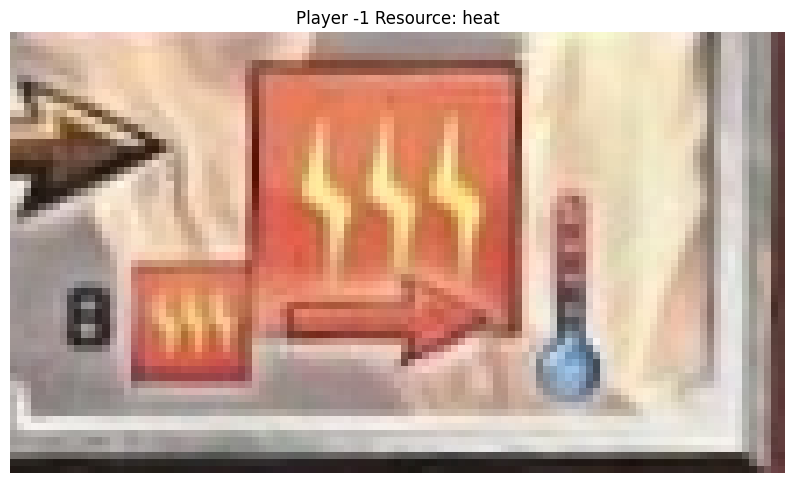

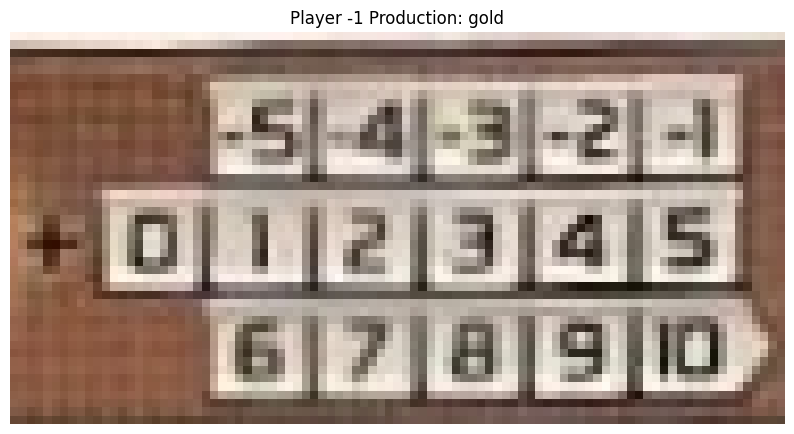

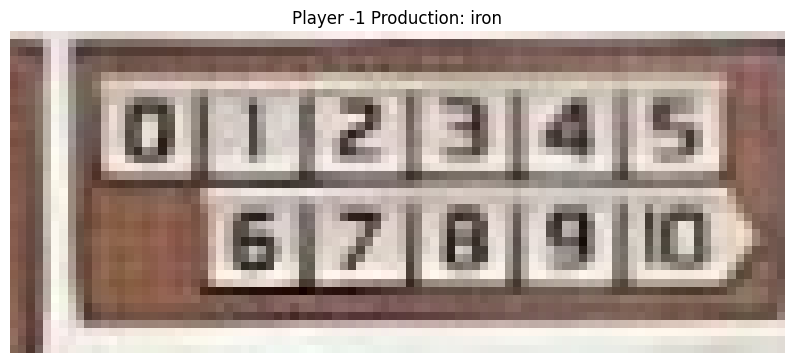

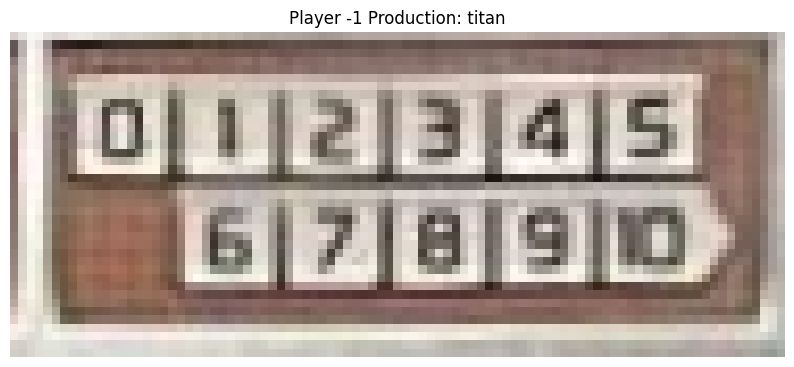

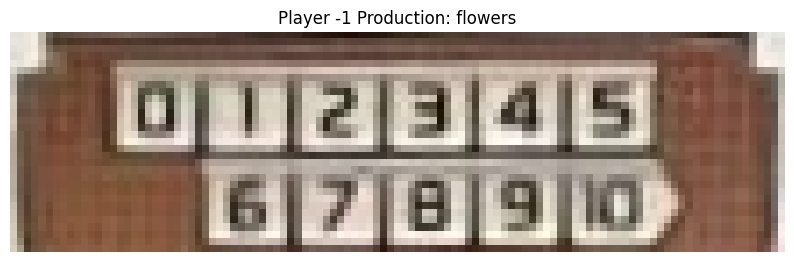

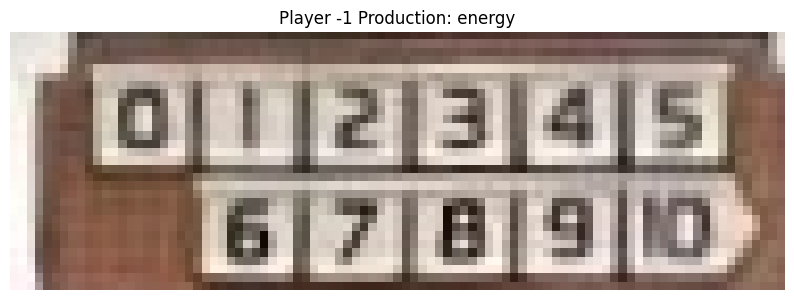

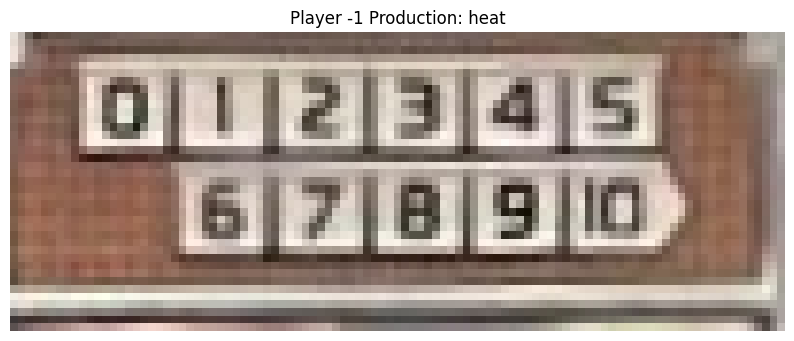

In [12]:
def segment_player_board(images):
    """
    Segments a Terraforming Mars player board into resource and production zones
    based on relative grid coordinates.
    """
    
    # Helper function to crop based on fractional coordinates
    # geometric_spec = (y_start, y_end, y_total, x_start, x_end, x_total)
    def get_crop(spec,image):
        x_s, x_e, x_div,y_s, y_e, y_div = spec
        
        # Calculate pixel coordinates
        y1 = int((y_s / y_div) * h)
        y2 = int((y_e / y_div) * h)
        x1 = int((x_s / x_div) * w)
        x2 = int((x_e / x_div) * w)
        return image[y1:y2, x1:x2]

    # 1. Define the 12 segments based on your prompt's coordinate list
    # Format: (y_start, y_end, y_denom, x_start, x_end, x_denom)
    specs = [
        (2, 18, 44,  1, 11, 32),   # Seg 1: Gold Res
        ( 6, 18, 44,11, 17, 32),  # Seg 2: Gold Prod
        
        (18, 31, 44, 1, 11, 32),   # Seg 3: Iron Res
        (18, 30, 44, 11, 16, 32),  # Seg 4: Iron Prod
        
        (31, 43, 44, 1, 11, 32),   # Seg 5: Titan Res
        ( 30, 42, 44,11, 16, 32),  # Seg 6: Titan Prod
        
        (2, 16, 44,  23, 31, 32),  # Seg 7: Flowers Res (Plants)
        (2, 16, 44 ,18, 22, 32),  # Seg 8: Flowers Prod
        
        (16, 28, 44, 23, 31, 32),  # Seg 9: Energy Res
        ( 16, 28, 44,18, 22, 32),  # Seg 10: Energy Prod
        
        (29, 43, 44, 23, 31, 32),  # Seg 11: Heat Res
        ( 29, 42, 44,18, 23, 32),   # Seg 12: Heat Prod
    ]  

    result_dict ={}
    for idx, image in enumerate(images):
        h, w = image.shape[:2]

        # 2. Extract all segments into a list (0-indexed, so seg1 is segments[0])
        segments=[]
        for spec in specs:
            segments.append(get_crop(spec, image))
        # 3. Construct the requested dictionary structure
        # Note: Mapping prompt "seg1" -> segments[0], etc.
        cur_dict = {
            "img": image,
            "resources": {
                "gold":    segments[0],  # seg1
                "iron":    segments[2],  # seg3
                "titan":   segments[4],  # seg5
                "flowers": segments[6],  # seg7
                "energy":  segments[8],  # seg9
                "heat":    segments[10]  # seg11
            },
            "production": {
                "gold":    segments[1],  # seg2
                "iron":    segments[3],  # seg4
                "titan":   segments[5],  # seg6
                "flowers": segments[7],  # seg8
                "energy":  segments[9],  # seg10
                "heat":    segments[11]  # seg12
            }
        }
        result_dict[idx] = cur_dict
    image = ref_board
    h, w = image.shape[:2]
    segments=[]
    for spec in specs:
        segments.append(get_crop(spec, image))
    cur_dict = {
            "img": image,
            "resources": {
                "gold":    segments[0],  # seg1
                "iron":    segments[2],  # seg3
                "titan":   segments[4],  # seg5
                "flowers": segments[6],  # seg7
                "energy":  segments[8],  # seg9
                "heat":    segments[10]  # seg11
            },
            "production": {
                "gold":    segments[1],  # seg2
                "iron":    segments[3],  # seg4
                "titan":   segments[5],  # seg6
                "flowers": segments[7],  # seg8
                "energy":  segments[9],  # seg10
                "heat":    segments[11]  # seg12
            }
        }
    result_dict[-1] = cur_dict
    return result_dict

segmented_boards = segment_player_board(player_board_images)

for pid, pdata in segmented_boards.items():
    print(f"Player {pid} Board Segments:")
    for res_name, res_img in pdata['resources'].items():
        show_inline(res_img, f"Player {pid} Resource: {res_name}")
    for prod_name, prod_img in pdata['production'].items():
        show_inline(prod_img, f"Player {pid} Production: {prod_name}")

In [15]:
import cv2
import numpy as np


def find_grid_by_big_contour(img,is_gold):
    if img is None: return
    
    debug_img = img.copy()

    # --- 1. Preprocessing (Your existing pipeline) ---
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(lab, (3, 3), 0)

    # Adaptive Threshold
    # Block Size 25: Looks at local area size (good for characters)
    # C = 5: Subtracts constant to separate foreground
    closed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8))
    target_percentile = 45
    
    dynamic_thresh_val = np.percentile(closed, target_percentile)
    
    
    thresh = cv2.threshold(closed, dynamic_thresh_val, 255, cv2.THRESH_BINARY)[1]
    # Close small holes (numbers)
    show_inline(thresh, "Thresholded Image")
    show_inline(closed, "Closed L Channel")
    # --- 3. Find the Main Bounding Box ---
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("No contours found.")
        return

    # Pick the largest area contour (The Grid)
    big_contour = max(contours, key=cv2.contourArea)
    bx, by, bw, bh = cv2.boundingRect(big_contour)
    # Draw the main bounding box (Blue)
    cv2.rectangle(debug_img, (bx, by), (bx+bw, by+bh), (255, 0, 0), 2)
    show_inline(debug_img, "Detected Big Contour Bounding Box")
    # --- 4. Mathematically Slice the Grid ---
    # The middle row is the widest (6 squares).
    
    if not is_gold:
        num_units_wide = 6 # Total squares in the widest row
        unit_width_float = bw / num_units_wide 
        unit_height = bh // 2 # Still using integer division for height

        final_squares = []

        # Row 2 (Middle) - 6 squares
        for i in range(num_units_wide):
            # Calculate x, x+w using the EXACT fraction of bw
            x = bx + round(i * unit_width_float)
            x_end = bx + round((i + 1) * unit_width_float)
            w = x_end - x # This ensures the sum of widths equals bw
            y = by 
            h = unit_height
            final_squares.append((x, y, w, h))

        # Row 3 (Bottom) - 5 squares, Indented by 1 unit
        # The indentation starts at the width of 1 unit
        indentation_x = bx + round(1 * unit_width_float) 
        # The loop runs from unit 1 to unit 6 (for 5 squares)
        for i in range(1, 6): 
            x = bx + round(i * unit_width_float)
            x_end = bx + round((i + 1) * unit_width_float)
            w = x_end - x
            y = by + unit_height 
            h = unit_height
            final_squares.append((x, y, w, h))
    else:
        sq_w = bw // 6
        sq_h = bh // 3
        
        final_squares = []
        
        # Row 1: Top (5 squares, Indented by 1 unit)
        # Starts at bx + sq_w
        for i in range(5):
            x = bx + int(sq_w*1.1) + (i * sq_w)
            y = by 
            final_squares.append((x, y, sq_w, sq_h))

        # Row 2: Middle (6 squares, No indentation)
        # Starts at bx
        for i in range(6):
            x = bx + int(sq_w*0.1)+ (i * sq_w)
            y = by + int(sq_h*1.1)
            final_squares.append((x, y, sq_w, sq_h))

        # Row 3: Bottom (5 squares, Indented by 1 unit)
        for i in range(5):
            x = bx + int(sq_w*1.1) + (i * sq_w)
            y = by + int(sq_h*2.2)
            final_squares.append((x, y, sq_w, sq_h))
    # --- 5. Visualization ---
    for i, (sx, sy, sw, sh) in enumerate(final_squares):
        # Draw the calculated square (Green)
        cv2.rectangle(debug_img, (sx, sy), (sx+sw, sy+sh), (0, 255, 0), 2)
    show_inline(debug_img, "Final Grid (Sliced from Big Contour)")
    contour_coords = (bx, by, bw, bh)
    return final_squares,contour_coords




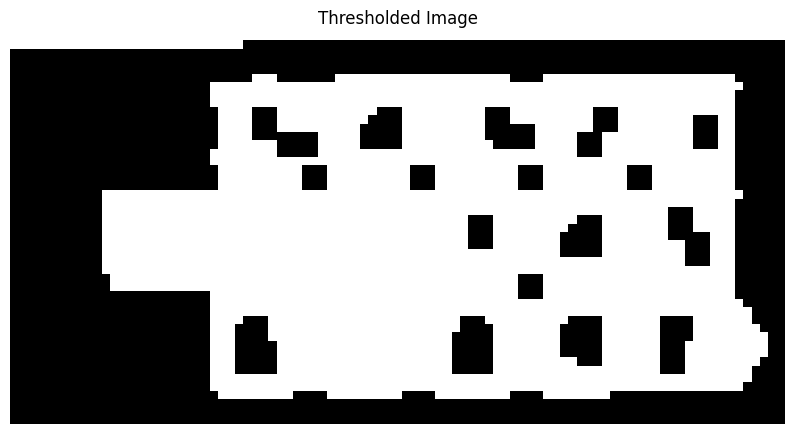

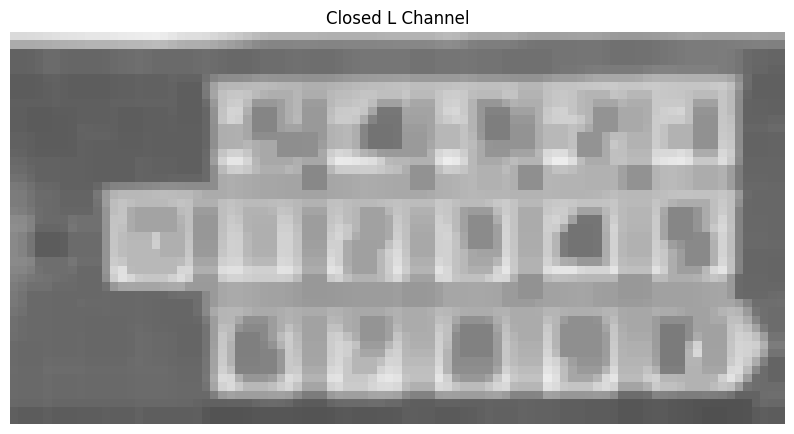

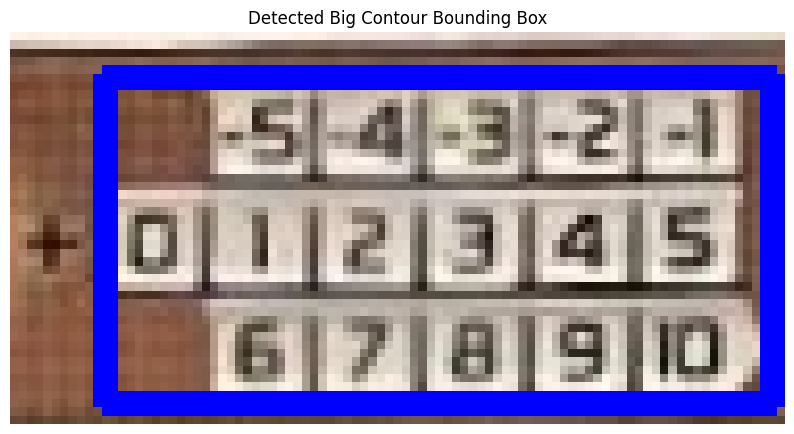

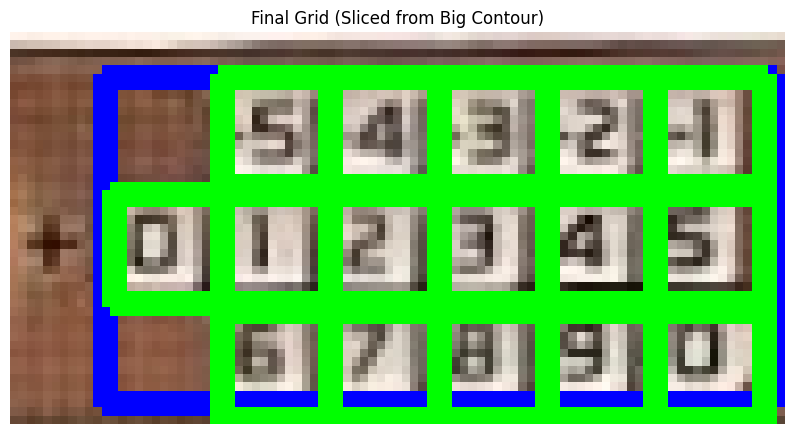

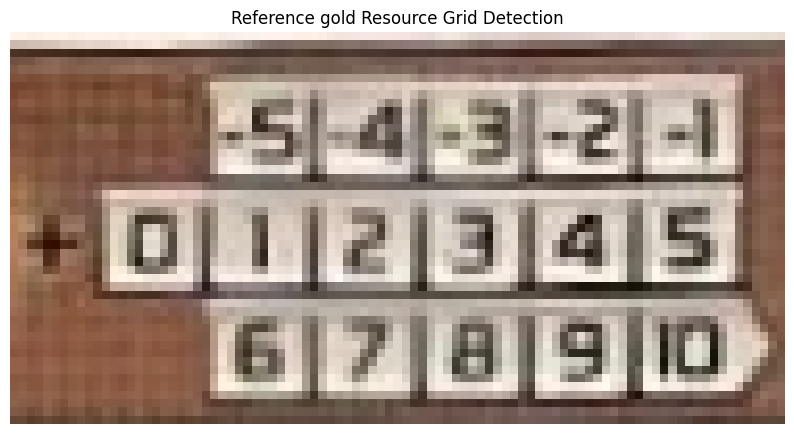

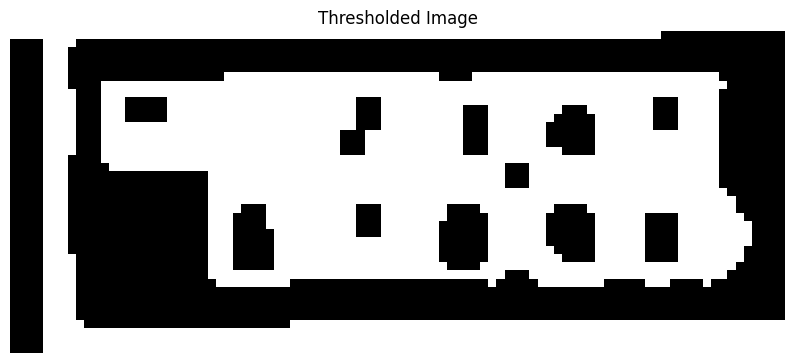

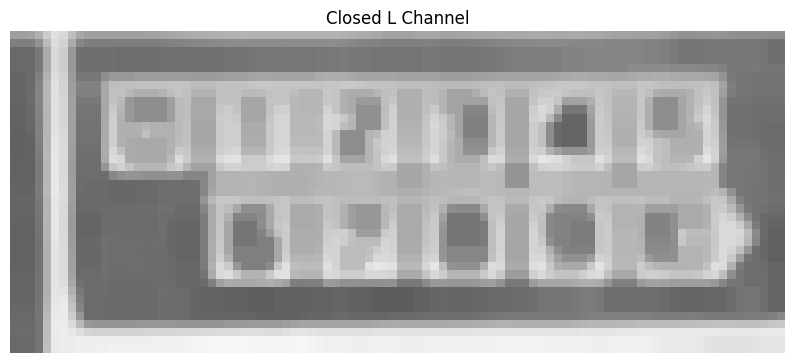

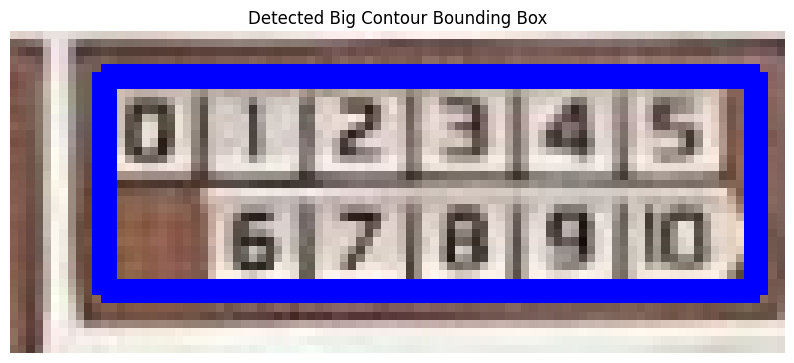

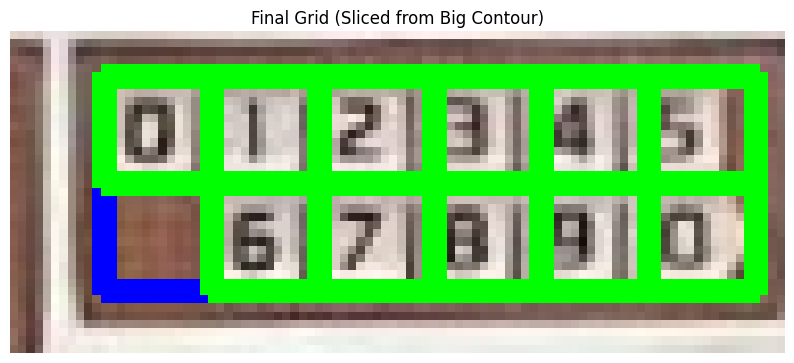

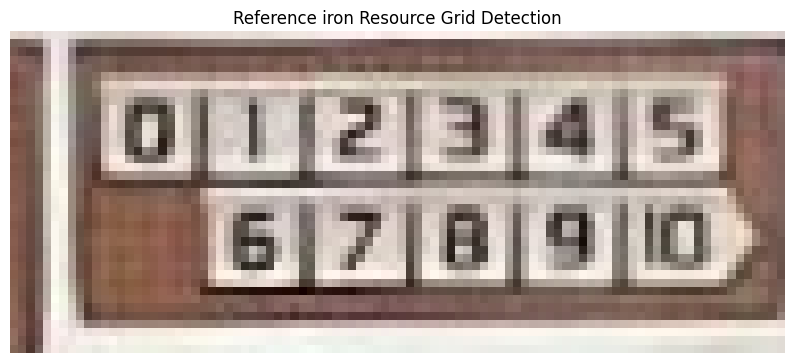

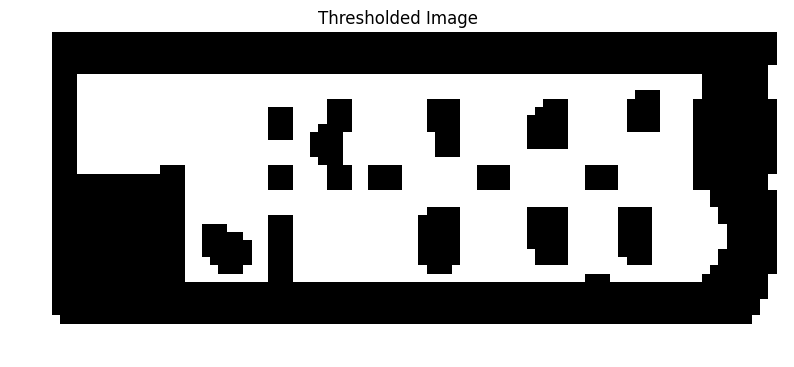

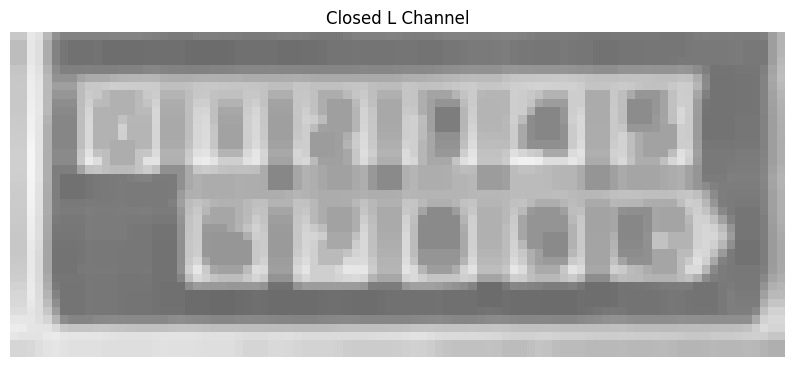

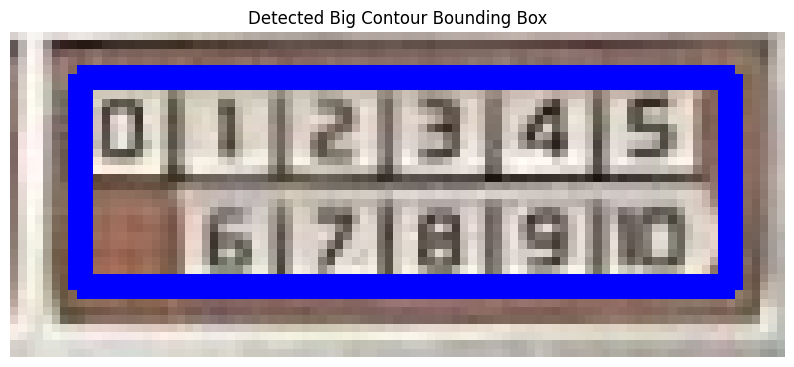

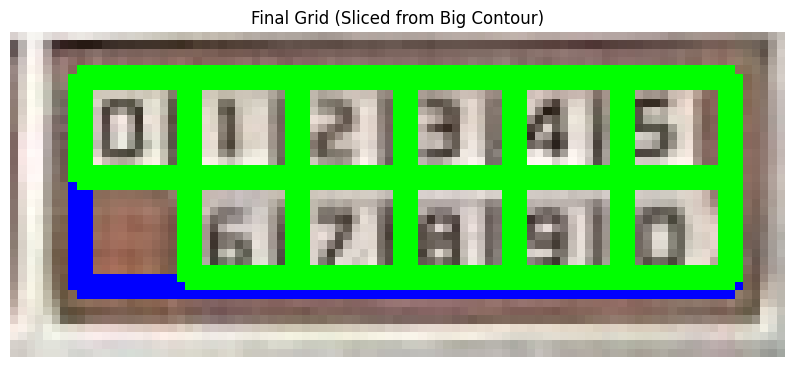

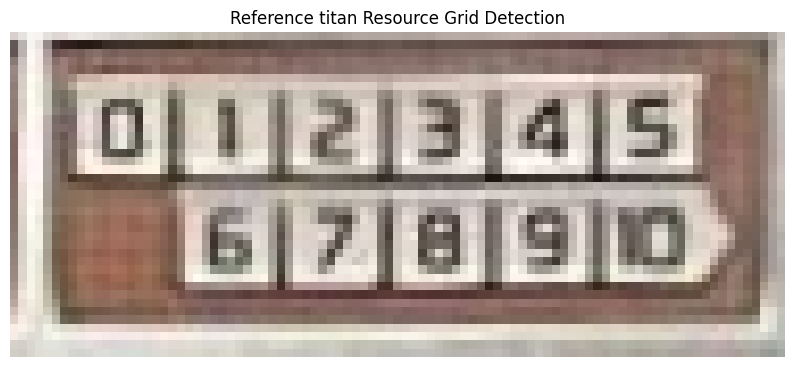

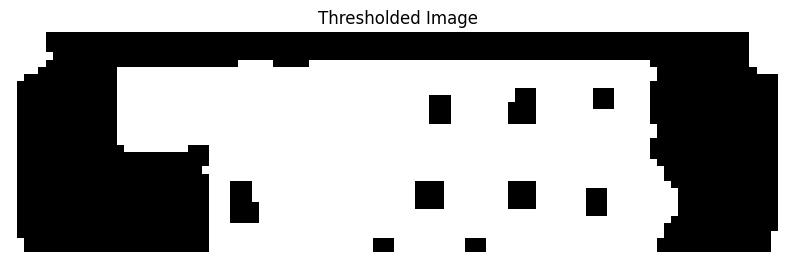

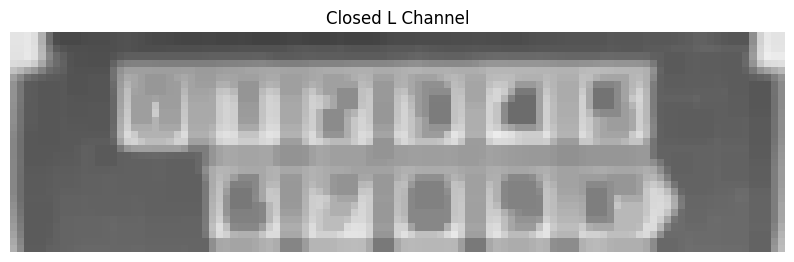

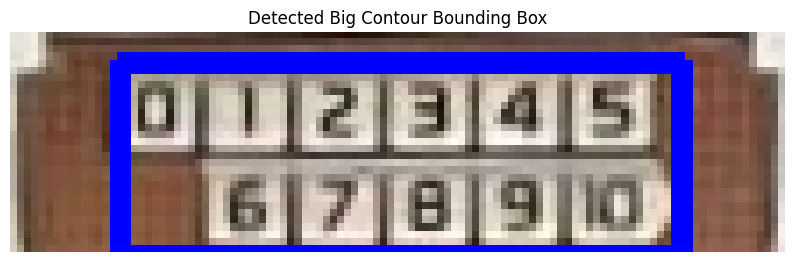

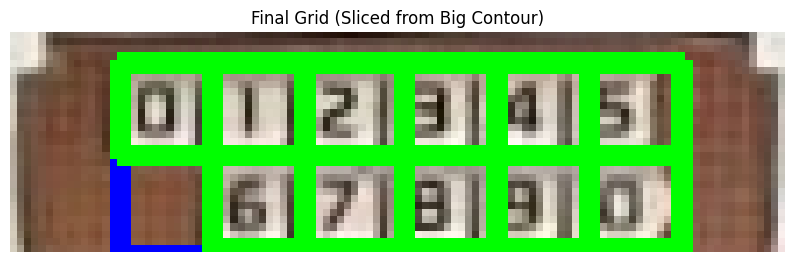

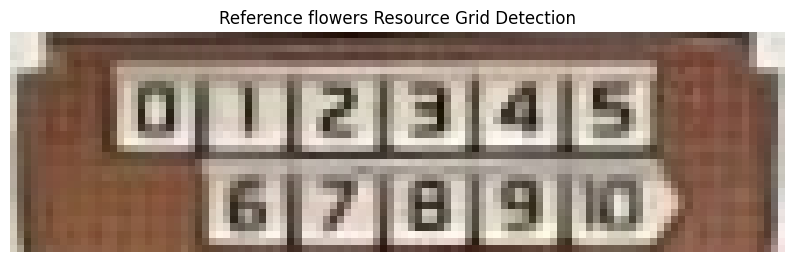

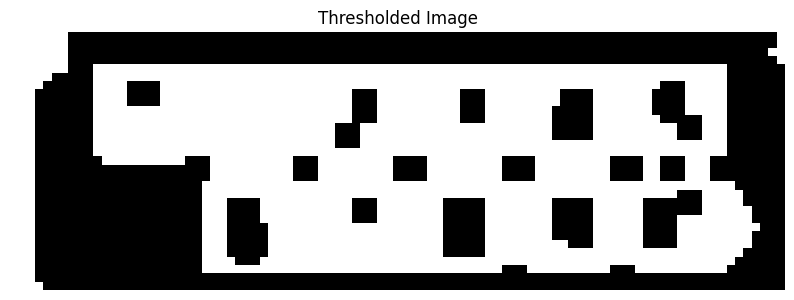

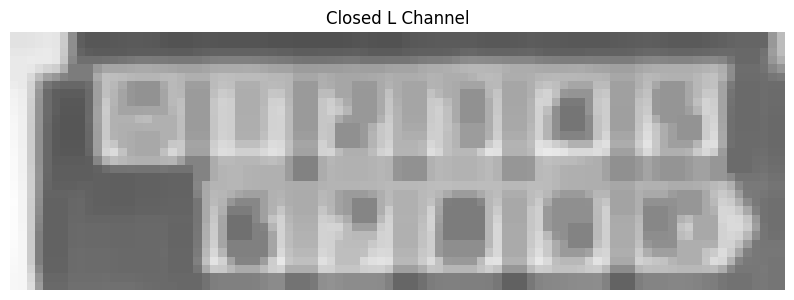

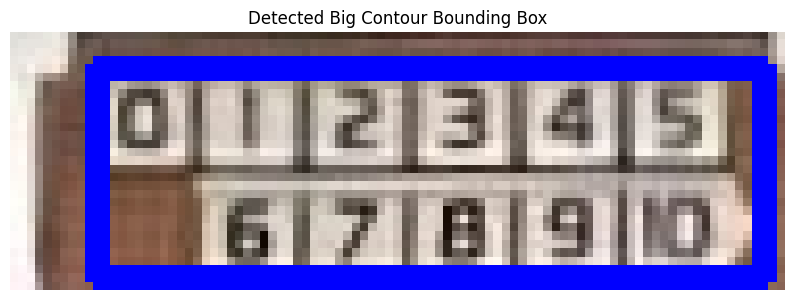

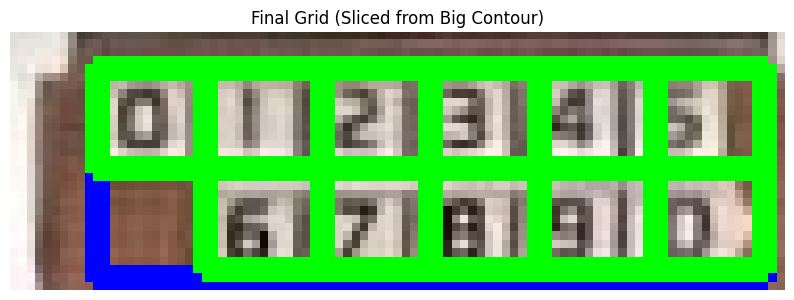

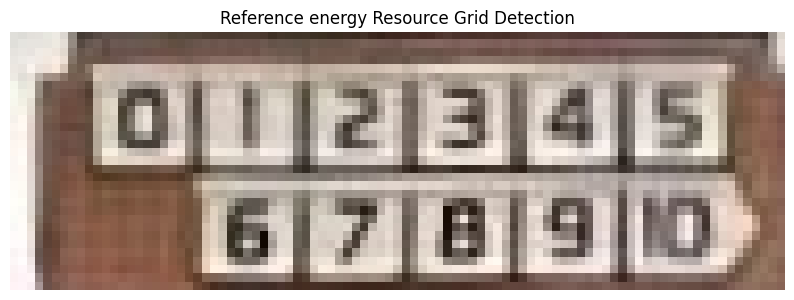

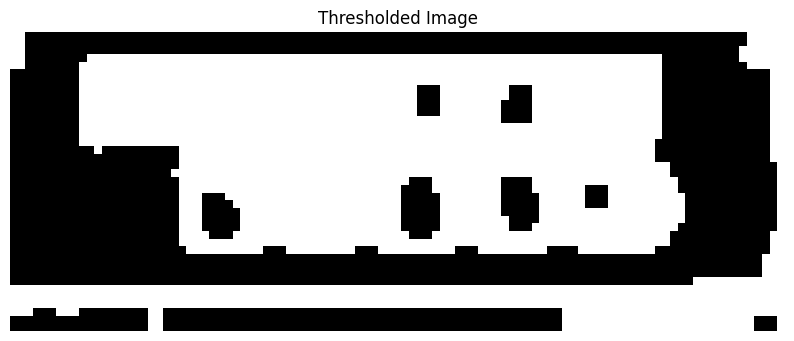

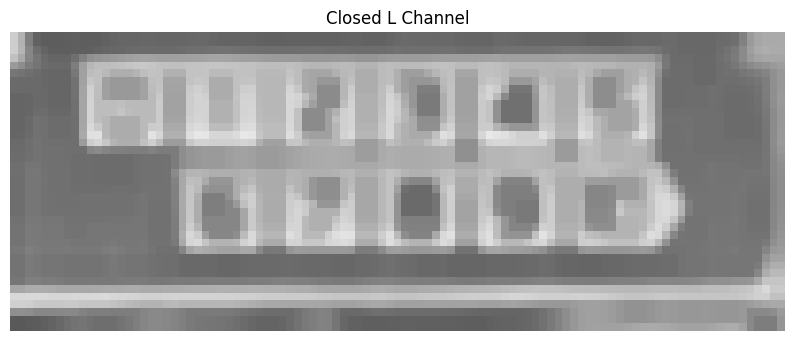

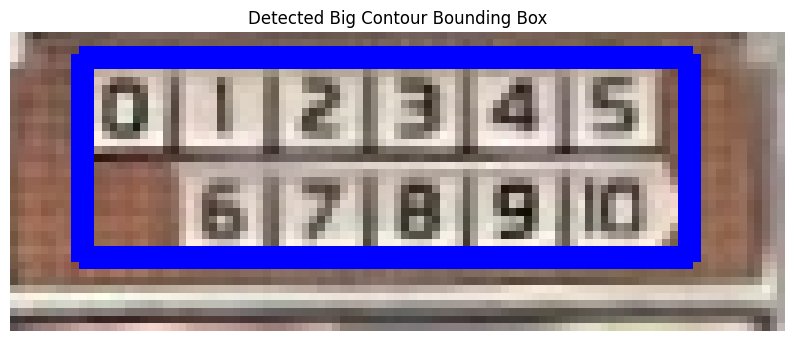

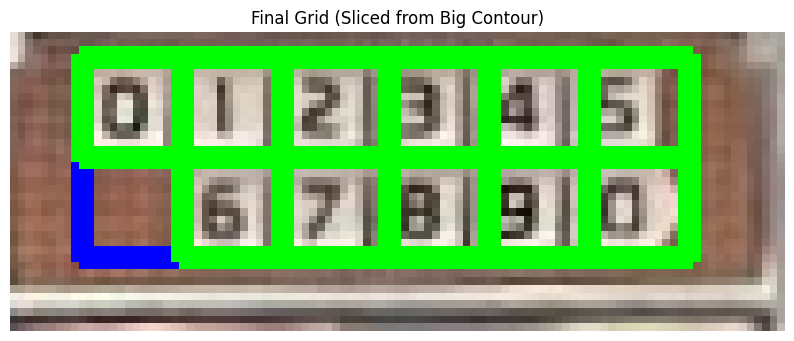

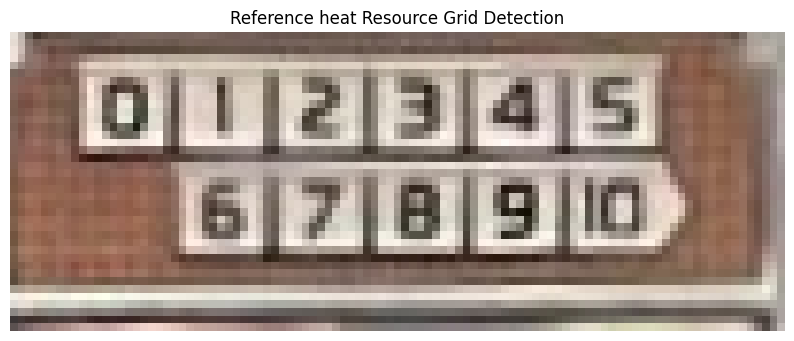

In [16]:
ref_contours = {}
for resource in segmented_boards[-1]['production'].items():
    res_name, res_img = resource
    if res_name == 'gold':
        squares,big_contour_coords = find_grid_by_big_contour(res_img, is_gold=True)
    else:  
        squares,big_contour_coords = find_grid_by_big_contour(res_img, is_gold=False)
    ref_contours[res_name] = res_img,big_contour_coords,squares
    show_inline(res_img, f"Reference {res_name} Resource Grid Detection")


In [17]:
img,rec_coords,squares = ref_contours['gold']
print(f"Reference Big Contour: x={rec_coords[0]}, y={rec_coords[1]}, w={rec_coords[2]}, h={rec_coords[3]}")

Reference Big Contour: x=11, y=5, w=80, h=39


Scale Factors: X=0.75, Y=0.79
New Box on Target: (6, 2, 59, 20)


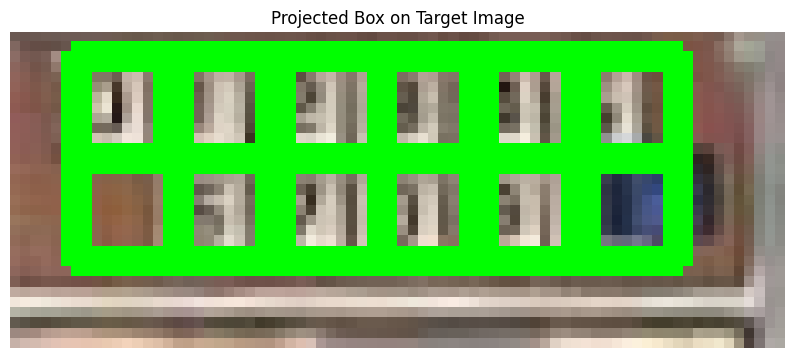

In [24]:
import cv2
import numpy as np

def project_box_by_scaling(ref_img, target_img, ref_box,ref_squares):
    
    # 1. Get dimensions of both images
    h_ref, w_ref = ref_img.shape[:2]
    h_tgt, w_tgt = target_img.shape[:2]

    if h_ref == 0 or w_ref == 0:
        raise ValueError("Reference image has 0 dimension.")

    # 2. Calculate Scale Factors
    # (How much bigger/smaller is the target compared to reference?)
    sx = w_tgt / w_ref
    sy = h_tgt / h_ref

    # 3. Unpack the reference box
    bx, by, bw, bh = ref_box

    # 4. Apply Scaling
    new_bx = int(bx * sx)
    new_by = int(by * sy)
    new_bw = int(bw * sx)
    new_bh = int(bh * sy)
    new_squares = []
    for (sx_ref, sy_ref, sw_ref, sh_ref) in ref_squares:
        nsx = int(sx_ref * sx)
        nsy = int(sy_ref * sy)
        nsw = int(sw_ref * sx)
        nsh = int(sh_ref * sy)
        new_squares.append((nsx, nsy, nsw, nsh))
    return (new_bx, new_by, new_bw, new_bh),new_squares, (sx, sy)

# ==========================================
# Example Usage
# ==========================================

# 1. Load your specific data
resource = 'heat'
ref_img = ref_contours[resource][0]       # From your dictionary
target_img = segmented_boards[0]['production'][resource] # Load your actual target crop
# Note: Ensure you load the target image correctly (e.g., cropping it from the main board first)

# The box you found on the reference (x, y, w, h)
# This represents the blue box around the numbers
ref_box = ref_contours[resource][1] 

# 2. Project the box
new_box,new_squares, scales = project_box_by_scaling(ref_img, target_img, ref_box, ref_contours[resource][2])

print(f"Scale Factors: X={scales[0]:.2f}, Y={scales[1]:.2f}")
print(f"New Box on Target: {new_box}")

# 3. Visualize
debug_img = target_img.copy()
nx, ny, nw, nh = new_box

# Draw the projected rectangle
cv2.rectangle(debug_img, (nx, ny), (nx + nw, ny + nh), (0, 255, 0), 2)
for i, (sx, sy, sw, sh) in enumerate(new_squares):
        # Draw the calculated square (Green)
        cv2.rectangle(debug_img, (sx, sy), (sx+sw, sy+sh), (0, 255, 0), 2)
show_inline(debug_img, "Projected Box on Target Image")

[(6, 2, 9, 10), (16, 2, 9, 10), (26, 2, 10, 10), (36, 2, 9, 10), (46, 2, 9, 10), (56, 2, 9, 10), (16, 12, 9, 10), (26, 12, 10, 10), (36, 12, 9, 10), (46, 12, 9, 10), (56, 12, 9, 10)]
The odd square is at Index: 10 (Distance: 77.44)


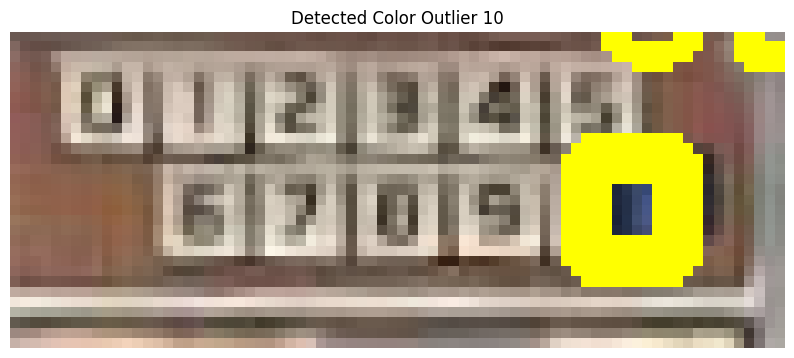

In [30]:

def detect_color_outlier(img, squares):
    """
    Analyzes the list of square coordinates and returns the index 
    of the square with the most distinct color.
    """
    means = []
    print(squares)
    for i, (x, y, w, h) in enumerate(squares):
        # 1. Extract ROI
        roi = img[y:y+h, x:x+w]
        
        # 2. Crop to the center (avoid grid lines/borders)
        # We shave off 20% from each side to get the "pure" tile color
        margin_x = int(w * 0.2)
        margin_y = int(h * 0.2)
        
        # Safety check to ensure roi is valid
        if roi.shape[0] <= 2*margin_y or roi.shape[1] <= 2*margin_x:
            center_roi = roi # Fallback if square is tiny
        else:
            center_roi = roi[margin_y:h-margin_y, margin_x:w-margin_x]

        # 3. Convert to LAB Color Space (Better for color comparison)
        # (You can use BGR, but LAB is more robust for lighting variations)
        roi_lab = cv2.cvtColor(center_roi, cv2.COLOR_BGR2LAB)
        
        # 4. Compute the mean color of this ROI
        # cv2.mean returns (c1, c2, c3, alpha), we only need first 3
        avg_color = cv2.mean(roi_lab)[:3]
        means.append(avg_color)

    # 5. Detect the Outlier
    means_np = np.array(means)
    
    # Calculate the median color vector of the whole group
    # We use median because the outlier would skew the mean
    median_color = np.median(means_np, axis=0)
    
    # Calculate Euclidean distance of each square's color from the median
    distances = np.linalg.norm(means_np - median_color, axis=1)
    
    # The square with the max distance is our outlier
    outlier_idx = np.argmax(distances)
    max_dist = distances[outlier_idx]
    
    return outlier_idx, max_dist

# --- Usage Example ---

resource = 'heat'
# 1. Run your existing grid finder
target_img = segmented_boards[0]['production'][resource] # Load your actual target crop
contours,squares,_ = project_box_by_scaling(ref_img, target_img, ref_box, ref_contours[resource][2])

# 2. Find the odd square
outlier_index, confidence = detect_color_outlier(target_img, squares)

print(f"The odd square is at Index: {outlier_index} (Distance: {confidence:.2f})")

# 3. Visualization
debug_img_color = target_img.copy()

# Highlight the outlier
ox, oy, ow, oh = squares[outlier_index]

# Draw a thick yellow box around the winner
cv2.rectangle(debug_img_color, (ox, oy), (ox+ow, oy+oh), (0, 255, 255), 4)
cv2.putText(debug_img_color, "ODD ONE", (ox, oy - 10), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

show_inline(debug_img_color, f"Detected Color Outlier {outlier_index}")